In [36]:
#### Importe
import pandas as pd 
import numpy as np   
import string   

import nltk 
from nltk.corpus import stopwords 
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import gensim

from nrclex import NRCLex

import networkx as nx
from itertools import combinations


# spacy model must be installed first with 'python -m spacy download en_core_web_sm' in the terminal
import spacy

from wordcloud import WordCloud
from PIL import Image   

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


# # Redeanteile
# import numpy 
# from collections import Counter
# import re

# from datetime import datetime   
# from gensim.test.utils import get_tmpfile   
# from gensim.test.utils import common_texts  
# from gensim.models.doc2vec import Doc2Vec, TaggedDocument
# #from sklearn.model_selection import train_test_split
# import os # evtl. Chunking



In [37]:
# Downloads -woher weiß ich welche ich denen mitgeben muss?
nltk.download('stopwords')
nltk.download('wordnet') 
# nltk.download('averaged_perceptron_tagger') 
# nltk.download('maxent_ne_chunker')
# nltk.download('words')
nltk.download('wordnet')
# nltk.download('omw-1.4')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ACG\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ACG\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ACG\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [38]:
# Pfade der jeweiligen Dateien
# We are using kaggle's 'Harry Potter Movies Dataset', available at https://www.kaggle.com/datasets/maricinnamon/harry-potter-Movies-dataset.
# The ChDiCp are stored in 'Dialogue.csv' and using 'Chapters.csv' we can see, that the first film consists of chapters 1-34.
path_dialoge = '../Harry_Potter_Movies/Dialogue.csv'
path_charaktere = '../Harry_Potter_Movies/Characters.csv'
path_spells = '../Harry_Potter_Movies/Spells.csv'
path_Movies = '../Harry_Potter_Movies/Movies.csv'
path_chapters = '../Harry_Potter_Movies/Chapters.csv'
path_places = '../Harry_Potter_Movies/Places.csv'


In [39]:
# Bilder für Wordcloud einlesen
photo1 = Image.open('../Utils/hogwarts.jpg')
photo2 = Image.open('../Utils/harry-potter-silhouettes-4.jpg')

In [40]:
# Dialog-Daten einlesen
df_dialogues = pd.read_csv(path_dialoge, encoding='iso-8859-1')

# Now we can take a look at the Dataframe of film one:
# It consists of the Chapter ID, the Place ID, Character ID and is split into the ChDiCp.
df_dialogues

Dialogue ID  Chapter ID  Place ID  Character ID  \
0               1           1         8             4   
1               2           1         8             7   
2               3           1         8             4   
3               4           1         8             7   
4               5           1         8             4   
...           ...         ...       ...           ...   
7439         7440         234        71             1   
7440         7441         234        71            84   
7441         7442         234        71             1   
7442         7443         234        71             1   
7443         7444         234        71            84   

                                               Dialogue  
0     I should have known that you would be here...P...  
1     Good evening, Professor Dumbledore. Are the ru...  
2      I'm afraid so, Professor. The good, and the bad.  
3                                          And the boy?  
4                               Hagrid is bringing him.  
...                                                 ...  
7439  Then Slytherin House will have gained a wonder...  
7440                                            Really?  
7441                                            Really.  
7442                                             Ready?  
7443                                             Ready.  

[7444 rows x 5 columns]

In [41]:
# weitere Daten einlesen und zusammenführen
df_spells = pd.read_csv(path_spells)
df_places = pd.read_csv(path_places)
Movie = pd.read_csv(path_Movies)



df_characters = pd.read_csv(path_charaktere, encoding='ISO-8859-1')
df_ChDi = pd.merge(df_dialogues, df_characters, on='Character ID', how='left')
df_ChDi

df_movie = pd.read_csv(path_chapters, encoding='ISO-8859-1')
df_ChDiCp = pd.merge(df_ChDi, df_movie, on='Chapter ID', how='left')
df_ChDiCp


Dialogue ID  Chapter ID  Place ID  Character ID  \
0               1           1         8             4   
1               2           1         8             7   
2               3           1         8             4   
3               4           1         8             7   
4               5           1         8             4   
...           ...         ...       ...           ...   
7439         7440         234        71             1   
7440         7441         234        71            84   
7441         7442         234        71             1   
7442         7443         234        71             1   
7443         7444         234        71            84   

                                               Dialogue      Character Name  \
0     I should have known that you would be here...P...    Albus Dumbledore   
1     Good evening, Professor Dumbledore. Are the ru...  Minerva McGonagall   
2      I'm afraid so, Professor. The good, and the bad.    Albus Dumbledore   
3                                          And the boy?  Minerva McGonagall   
4                               Hagrid is bringing him.    Albus Dumbledore   
...                                                 ...                 ...   
7439  Then Slytherin House will have gained a wonder...        Harry Potter   
7440                                            Really?        Albus Potter   
7441                                            Really.        Harry Potter   
7442                                             Ready?        Harry Potter   
7443                                             Ready.        Albus Potter   

     Species  Gender       House Patronus Wand (Wood)         Wand (Core)  \
0      Human    Male  Gryffindor  Phoenix       Elder  Thestral Tail Hair   
1      Human  Female  Gryffindor      Cat         Fir  Dragon Heartstring   
2      Human    Male  Gryffindor  Phoenix       Elder  Thestral Tail Hair   
3      Human  Female  Gryffindor      Cat         Fir  Dragon Heartstring   
4      Human    Male  Gryffindor  Phoenix       Elder  Thestral Tail Hair   
...      ...     ...         ...      ...         ...                 ...   
7439   Human    Male  Gryffindor     Stag       Holly     Phoenix Feather   
7440   Human    Male   Slytherin      NaN         NaN                 NaN   
7441   Human    Male  Gryffindor     Stag       Holly     Phoenix Feather   
7442   Human    Male  Gryffindor     Stag       Holly     Phoenix Feather   
7443   Human    Male   Slytherin      NaN         NaN                 NaN   

              Chapter Name  Movie ID  Movie Chapter  
0        Doorstep Delivery         1              1  
1        Doorstep Delivery         1              1  
2        Doorstep Delivery         1              1  
3        Doorstep Delivery         1              1  
4        Doorstep Delivery         1              1  
...                    ...       ...            ...  
7439  Nineteen Years Later         8             26  
7440  Nineteen Years Later         8             26  
7441  Nineteen Years Later         8             26  
7442  Nineteen Years Later         8             26  
7443  Nineteen Years Later         8             26  

[7444 rows x 15 columns]

In [42]:
#### Preprocessing ####
## Normalization, Punctuation, Tokenization (NLTK), Stopwords  (radikaler als Gensim)

# alle Punctuation mit Leerzeichen austauschen (nötig für word-Tokenizier)
def remove_punctuations(text):                          
    for punctuation in string.punctuation:
        text = text.replace(punctuation,' ')
    return text

# Kleinschreibung, Funktion remove_punctuations anwenden, Tokenization
df_ChDiCp['Tokens'] = df_ChDiCp['Dialogue'].str.lower().apply(remove_punctuations).apply(nltk.word_tokenize)    
df_ChDiCp['Tokens']
df_ChDiCp

# Stopwordliste ausgeben
print(stopwords.words('english')) 

# Stopwords rausfiltern und in Data Frame df_ChDiCp abspeichern
dialoge = df_ChDiCp['Tokens'].tolist()
filtered_tokens = []
for line in dialoge:
    line_list = []
    for token in line:
        if token not in stopwords.words('english'):
            line_list.append(token)

    filtered_tokens.append(line_list)

df_ChDiCp['Tokens'] = filtered_tokens

# Ausgabe des DataFrames
df_ChDiCp

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Dialogue ID  Chapter ID  Place ID  Character ID  \
0               1           1         8             4   
1               2           1         8             7   
2               3           1         8             4   
3               4           1         8             7   
4               5           1         8             4   
...           ...         ...       ...           ...   
7439         7440         234        71             1   
7440         7441         234        71            84   
7441         7442         234        71             1   
7442         7443         234        71             1   
7443         7444         234        71            84   

                                               Dialogue      Character Name  \
0     I should have known that you would be here...P...    Albus Dumbledore   
1     Good evening, Professor Dumbledore. Are the ru...  Minerva McGonagall   
2      I'm afraid so, Professor. The good, and the bad.    Albus Dumbledore   
3                                          And the boy?  Minerva McGonagall   
4                               Hagrid is bringing him.    Albus Dumbledore   
...                                                 ...                 ...   
7439  Then Slytherin House will have gained a wonder...        Harry Potter   
7440                                            Really?        Albus Potter   
7441                                            Really.        Harry Potter   
7442                                             Ready?        Harry Potter   
7443                                             Ready.        Albus Potter   

     Species  Gender       House Patronus Wand (Wood)         Wand (Core)  \
0      Human    Male  Gryffindor  Phoenix       Elder  Thestral Tail Hair   
1      Human  Female  Gryffindor      Cat         Fir  Dragon Heartstring   
2      Human    Male  Gryffindor  Phoenix       Elder  Thestral Tail Hair   
3      Human  Female  Gryffindor      Cat         Fir  Dragon Heartstring   
4      Human    Male  Gryffindor  Phoenix       Elder  Thestral Tail Hair   
...      ...     ...         ...      ...         ...                 ...   
7439   Human    Male  Gryffindor     Stag       Holly     Phoenix Feather   
7440   Human    Male   Slytherin      NaN         NaN                 NaN   
7441   Human    Male  Gryffindor     Stag       Holly     Phoenix Feather   
7442   Human    Male  Gryffindor     Stag       Holly     Phoenix Feather   
7443   Human    Male   Slytherin      NaN         NaN                 NaN   

              Chapter Name  Movie ID  Movie Chapter  \
0        Doorstep Delivery         1              1   
1        Doorstep Delivery         1              1   
2        Doorstep Delivery         1              1   
3        Doorstep Delivery         1              1   
4        Doorstep Delivery         1              1   
...                    ...       ...            ...   
7439  Nineteen Years Later         8             26   
7440  Nineteen Years Later         8             26   
7441  Nineteen Years Later         8             26   
7442  Nineteen Years Later         8             26   
7443  Nineteen Years Later         8             26   

                                                 Tokens  
0                 [known, would, professor, mcgonagall]  
1     [good, evening, professor, dumbledore, rumours...  
2                        [afraid, professor, good, bad]  
3                                                 [boy]  
4                                    [hagrid, bringing]  
...                                                 ...  
7439  [slytherin, house, gained, wonderful, wizard, ...  
7440                                           [really]  
7441                                           [really]  
7442                                            [ready]  
7443                                            [ready]  

[7444 rows x 16 columns]

In [43]:
#### Preprocessing
## Gensim Preprocessing

def preprocess(row):
    return gensim.utils.simple_preprocess(row['Dialogue'])

df_ChDiCp['Tokens_Gensim'] = df_ChDiCp.apply(preprocess, axis=1)
print(df_ChDiCp['Tokens_Gensim'].head(20))

0     [should, have, known, that, you, would, be, he...
1     [good, evening, professor, dumbledore, are, th...
2     [afraid, so, professor, the, good, and, the, bad]
3                                       [and, the, boy]
4                           [hagrid, is, bringing, him]
5     [do, you, think, it, wise, to, trust, hagrid, ...
6     [ah, professor, would, trust, hagrid, with, my...
7     [professor, dumbledore, sir, professor, mcgona...
8                         [no, problems, trust, hagrid]
9     [no, sir, little, tyke, fell, asleep, just, as...
10    [albus, do, you, really, think, it, safe, leav...
11                         [the, only, family, he, has]
12    [this, boy, will, be, famous, there, won, be, ...
13    [exactly, he, better, off, growing, up, away, ...
14    [there, there, hagrid, it, not, really, goodby...
15                          [good, luck, harry, potter]
16                                   [up, get, up, now]
17      [wake, up, cousin, we, re, going, to, th

In [44]:
#### Preprocessing
## Part of Speech tagging (POS)

def pos_tag_text(row):
    # tokens holen
    tokens = row['Tokens_Gensim'] # -->Tokens war davor !!

    # POS-Tagging durchführen
    pos_tags = nltk.pos_tag(tokens)
    
    return pos_tags

# Anwendung der pos_tag_text() Funktion auf die Spalte Dialogue
df_ChDiCp['pos_tags'] = df_ChDiCp.apply(pos_tag_text, axis=1)
df_ChDiCp['pos_tags'][9]

[('no', 'DT'),
 ('sir', 'JJ'),
 ('little', 'JJ'),
 ('tyke', 'NN'),
 ('fell', 'VBD'),
 ('asleep', 'RB'),
 ('just', 'RB'),
 ('as', 'IN'),
 ('we', 'PRP'),
 ('were', 'VBD'),
 ('flying', 'VBG'),
 ('over', 'IN'),
 ('bristol', 'NN'),
 ('heh', 'NNS'),
 ('try', 'VBP'),
 ('not', 'RB'),
 ('to', 'TO'),
 ('wake', 'VB'),
 ('him', 'PRP'),
 ('there', 'RB'),
 ('you', 'PRP'),
 ('go', 'VBP')]

In [45]:
#### Preprocessing
### Stemming & Lemmatization

# Vorbereitung für Stemming und Lemmatization & extra Data Frame für beide Methoden
dialoge = df_ChDiCp['Tokens_Gensim']

df_StemLem = pd.DataFrame({'Wort': [] ,'Porter': [] , 'Snowball': [], 'Lancaster': []})
df_StemLem['Wort'] = df_ChDiCp['Tokens']


### Stemming
porter = PorterStemmer()
lancaster = LancasterStemmer()
snowball = SnowballStemmer(language='english')

## PorterStemmer
PorterStem = []
for line in dialoge:
    list_line = []
    for word in line:
        list_line.append(porter.stem(word)) 
    PorterStem.append(list_line)
PorterStem
df_StemLem['Porter'] = PorterStem
df_StemLem

## SnowballStemmer
SnowballStem = []
for line in dialoge:
    list_line = []
    for word in line:
        list_line.append(snowball.stem(word))
    SnowballStem.append(list_line)
SnowballStem
df_StemLem['Snowball'] = SnowballStem

## LancasterStemmer
LancasterStem = []
for line in dialoge:
    list_line = []
    for word in line:
        list_line.append(lancaster.stem(word))
    LancasterStem.append(list_line)
LancasterStem
df_StemLem['Lancaster'] = LancasterStem
df_StemLem.head(12)


### Lemmitization
wnl = WordNetLemmatizer()

# übergebene POS tags werden überschrieben, da Lemmatizer nicht mit POS tags arbeiten kann
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else: 
        return None

# Funktion get_wordnet_pos, Lemmatization und Gegenüberstellung von den Stemmern und Lemmitization
# fell: als Veb von POS erkannt --> liegt in Lemmatisier vor --> wird aber nicht in Grundform zurückfomiert
lemma = []
for line in df_ChDiCp['pos_tags']:
    line_lemma = []
    i=0
    for word, tag in line:
        # POS tag wird überschrieben
        wntag = get_wordnet_pos(tag)
        # print(word, wntag)

        # Lemmatization
        if wntag is None:
            line_lemma.append( wnl.lemmatize(word))
        else:
            line_lemma.append(wnl.lemmatize(word, pos = wntag))
        
        # Gegenüberstellung von Stemmern und Lemmitization pro Wort
        print([word , porter.stem(word),snowball.stem(word), lancaster.stem(word), line_lemma[i]])
        #print(word, line_lemma[i])
        i += 1

    lemma.append(line_lemma)    
lemma
df_StemLem['Lemmatization'] = lemma
df_StemLem.head(12)
# print(wordnet) -> kann man sich Wordnet anschauen

['should', 'should', 'should', 'should', 'should']
['have', 'have', 'have', 'hav', 'have']
['known', 'known', 'known', 'known', 'know']
['that', 'that', 'that', 'that', 'that']
['you', 'you', 'you', 'you', 'you']
['would', 'would', 'would', 'would', 'would']
['be', 'be', 'be', 'be', 'be']
['here', 'here', 'here', 'her', 'here']
['professor', 'professor', 'professor', 'profess', 'professor']
['mcgonagall', 'mcgonagal', 'mcgonagal', 'mcgonagall', 'mcgonagall']
['good', 'good', 'good', 'good', 'good']
['evening', 'even', 'even', 'ev', 'evening']
['professor', 'professor', 'professor', 'profess', 'professor']
['dumbledore', 'dumbledor', 'dumbledor', 'dumbl', 'dumbledore']
['are', 'are', 'are', 'ar', 'be']
['the', 'the', 'the', 'the', 'the']
['rumours', 'rumour', 'rumour', 'rumo', 'rumour']
['true', 'true', 'true', 'tru', 'true']
['albus', 'albu', 'albus', 'alb', 'albus']
['afraid', 'afraid', 'afraid', 'afraid', 'afraid']
['so', 'so', 'so', 'so', 'so']
['professor', 'professor', 'professor'

Wort  \
0               [known, would, professor, mcgonagall]   
1   [good, evening, professor, dumbledore, rumours...   
2                      [afraid, professor, good, bad]   
3                                               [boy]   
4                                  [hagrid, bringing]   
5   [think, wise, trust, hagrid, something, import...   
6         [ah, professor, would, trust, hagrid, life]   
7   [professor, dumbledore, sir, professor, mcgona...   
8                           [problems, trust, hagrid]   
9   [sir, little, tyke, fell, asleep, flying, bris...   
10  [albus, really, think, safe, leaving, people, ...   
11                                           [family]   

                                               Porter  \
0   [should, have, known, that, you, would, be, he...   
1   [good, even, professor, dumbledor, are, the, r...   
2   [afraid, so, professor, the, good, and, the, bad]   
3                                     [and, the, boy]   
4                            [hagrid, is, bring, him]   
5   [do, you, think, it, wise, to, trust, hagrid, ...   
6   [ah, professor, would, trust, hagrid, with, my...   
7   [professor, dumbledor, sir, professor, mcgonagal]   
8                        [no, problem, trust, hagrid]   
9   [no, sir, littl, tyke, fell, asleep, just, as,...   
10  [albu, do, you, realli, think, it, safe, leav,...   
11                        [the, onli, famili, he, ha]   

                                             Snowball  \
0   [should, have, known, that, you, would, be, he...   
1   [good, even, professor, dumbledor, are, the, r...   
2   [afraid, so, professor, the, good, and, the, bad]   
3                                     [and, the, boy]   
4                            [hagrid, is, bring, him]   
5   [do, you, think, it, wise, to, trust, hagrid, ...   
6   [ah, professor, would, trust, hagrid, with, my...   
7   [professor, dumbledor, sir, professor, mcgonagal]   
8                        [no, problem, trust, hagrid]   
9   [no, sir, littl, tyke, fell, asleep, just, as,...   
10  [albus, do, you, realli, think, it, safe, leav...   
11                       [the, onli, famili, he, has]   

                                            Lancaster  \
0   [should, hav, known, that, you, would, be, her...   
1   [good, ev, profess, dumbl, ar, the, rumo, tru,...   
2     [afraid, so, profess, the, good, and, the, bad]   
3                                     [and, the, boy]   
4                            [hagrid, is, bring, him]   
5   [do, you, think, it, wis, to, trust, hagrid, w...   
6   [ah, profess, would, trust, hagrid, with, my, ...   
7          [profess, dumbl, sir, profess, mcgonagall]   
8                        [no, problem, trust, hagrid]   
9   [no, sir, littl, tyk, fel, asleep, just, as, w...   
10  [alb, do, you, real, think, it, saf, leav, him...   
11                           [the, on, famy, he, has]   

                                        Lemmatization  
0   [should, have, know, that, you, would, be, her...  
1   [good, evening, professor, dumbledore, be, the...  
2   [afraid, so, professor, the, good, and, the, bad]  
3                                     [and, the, boy]  
4                            [hagrid, be, bring, him]  
5   [do, you, think, it, wise, to, trust, hagrid, ...  
6   [ah, professor, would, trust, hagrid, with, my...  
7   [professor, dumbledore, sir, professor, mcgona...  
8                        [no, problem, trust, hagrid]  
9   [no, sir, little, tyke, fell, asleep, just, a,...  
10  [albus, do, you, really, think, it, safe, leav...  
11                      [the, only, family, he, have]

In [46]:
#### Preprocessing
### Chunking

def get_chunks(row):
    # pos_tags holen
    pos_tags = row['pos_tags']

    # chunks bekommen
    chunked = nltk.ne_chunk(pos_tags)

    return chunked
    
df_ChDiCp['chunks'] = df_ChDiCp.apply(get_chunks, axis=1)
df_ChDiCp['chunks']

0       [(should, MD), (have, VB), (known, VBN), (that...
1       [(good, JJ), (evening, NN), (professor, NN), (...
2       [(afraid, NNS), (so, RB), (professor, IN), (th...
3                       [(and, CC), (the, DT), (boy, NN)]
4       [(hagrid, NN), (is, VBZ), (bringing, VBG), (hi...
                              ...                        
7439    [(then, RB), (slytherin, NN), (house, NN), (wi...
7440                                       [(really, RB)]
7441                                       [(really, RB)]
7442                                        [(ready, JJ)]
7443                                        [(ready, JJ)]
Name: chunks, Length: 7444, dtype: object

In [47]:
#### Preprocessing
### Name Entity Recognition
# Englisches Modell laden
# spacy model must be installed first with 'python -m spacy download en_core_web_sm' in the terminal

nlp = spacy.load('en_core_web_sm')

def extract_entities(row):
    # Text verarbeiten
    doc = nlp(row['Dialogue'])
    
    # extrahiere named entities
    entities = ([(X.text, X.label_) for X in doc.ents])
    
    return entities


df_ChDiCp['all_entities_spacy_dial'] = df_ChDiCp.apply(extract_entities, axis=1)
df_ChDiCp

Dialogue ID  Chapter ID  Place ID  Character ID  \
0               1           1         8             4   
1               2           1         8             7   
2               3           1         8             4   
3               4           1         8             7   
4               5           1         8             4   
...           ...         ...       ...           ...   
7439         7440         234        71             1   
7440         7441         234        71            84   
7441         7442         234        71             1   
7442         7443         234        71             1   
7443         7444         234        71            84   

                                               Dialogue      Character Name  \
0     I should have known that you would be here...P...    Albus Dumbledore   
1     Good evening, Professor Dumbledore. Are the ru...  Minerva McGonagall   
2      I'm afraid so, Professor. The good, and the bad.    Albus Dumbledore   
3                                          And the boy?  Minerva McGonagall   
4                               Hagrid is bringing him.    Albus Dumbledore   
...                                                 ...                 ...   
7439  Then Slytherin House will have gained a wonder...        Harry Potter   
7440                                            Really?        Albus Potter   
7441                                            Really.        Harry Potter   
7442                                             Ready?        Harry Potter   
7443                                             Ready.        Albus Potter   

     Species  Gender       House Patronus Wand (Wood)         Wand (Core)  \
0      Human    Male  Gryffindor  Phoenix       Elder  Thestral Tail Hair   
1      Human  Female  Gryffindor      Cat         Fir  Dragon Heartstring   
2      Human    Male  Gryffindor  Phoenix       Elder  Thestral Tail Hair   
3      Human  Female  Gryffindor      Cat         Fir  Dragon Heartstring   
4      Human    Male  Gryffindor  Phoenix       Elder  Thestral Tail Hair   
...      ...     ...         ...      ...         ...                 ...   
7439   Human    Male  Gryffindor     Stag       Holly     Phoenix Feather   
7440   Human    Male   Slytherin      NaN         NaN                 NaN   
7441   Human    Male  Gryffindor     Stag       Holly     Phoenix Feather   
7442   Human    Male  Gryffindor     Stag       Holly     Phoenix Feather   
7443   Human    Male   Slytherin      NaN         NaN                 NaN   

              Chapter Name  Movie ID  Movie Chapter  \
0        Doorstep Delivery         1              1   
1        Doorstep Delivery         1              1   
2        Doorstep Delivery         1              1   
3        Doorstep Delivery         1              1   
4        Doorstep Delivery         1              1   
...                    ...       ...            ...   
7439  Nineteen Years Later         8             26   
7440  Nineteen Years Later         8             26   
7441  Nineteen Years Later         8             26   
7442  Nineteen Years Later         8             26   
7443  Nineteen Years Later         8             26   

                                                 Tokens  \
0                 [known, would, professor, mcgonagall]   
1     [good, evening, professor, dumbledore, rumours...   
2                        [afraid, professor, good, bad]   
3                                                 [boy]   
4                                    [hagrid, bringing]   
...                                                 ...   
7439  [slytherin, house, gained, wonderful, wizard, ...   
7440                                           [really]   
7441                                           [really]   
7442                                            [ready]   
7443                                            [ready]   

                                          Tokens_Gensim  \
0     [should, hav

In [48]:
#### Analyse ####
### Generelle Betrachtung der einzelnen Filme

## Filmgrenzen
Filmgrenzen = []
for i in Movie['Movie ID']:
    movie = df_ChDiCp[df_ChDiCp['Movie ID'] == i]
    Filmgrenzen.append(max(movie['Chapter ID']))   
Filmgrenzen

## Kapitelanzahl pro Film
AnzahlKapitel = []
for i in Movie['Movie ID']:
    movie = df_ChDiCp[df_ChDiCp['Movie ID'] == i]
    AnzahlKapitel.append(max(movie['Chapter ID'])-min(movie['Chapter ID'])+1)
AnzahlKapitel

# Anzahl Dialoge pro Film
AnzahlDialogeproFilm = []
AnzahlDialogeproFilm = df_ChDiCp['Movie ID'].value_counts() # jeden Movie extra

# Data Frame erzeugen
allgemein = pd.DataFrame(AnzahlDialogeproFilm).reset_index().rename(columns={'index': 'Movie ID', 'Movie ID': 'Anzahl Dialoge'}).sort_values(by = ['Movie ID'], ascending =True).reset_index()
allgemein['Kapitelanzahl'] = (AnzahlKapitel)
allgemein= allgemein.drop('index', axis = 1)
allgemein = allgemein.loc[:,['Movie ID', 'Kapitelanzahl', 'Anzahl Dialoge']]
allgemein['Runtime (min)'] = Movie['Runtime']
allgemein

Movie ID  Kapitelanzahl  Anzahl Dialoge  Runtime (min)
0         1             34             885            152
1         2             36             986            161
2         3             33             881            142
3         4             27             741            157
4         5             27            1157            138
5         6             26            1070            153
6         7             25            1012            146
7         8             26             712            130

5 häufigste Wörter über alle Filme:  [('harry', 712), ('know', 429), ('well', 374), ('one', 344), ('potter', 309)]
5 häufigste Wörter von Harry:  [('sir', 121), ('know', 111), ('think', 79), ('hermione', 78), ('one', 70)]


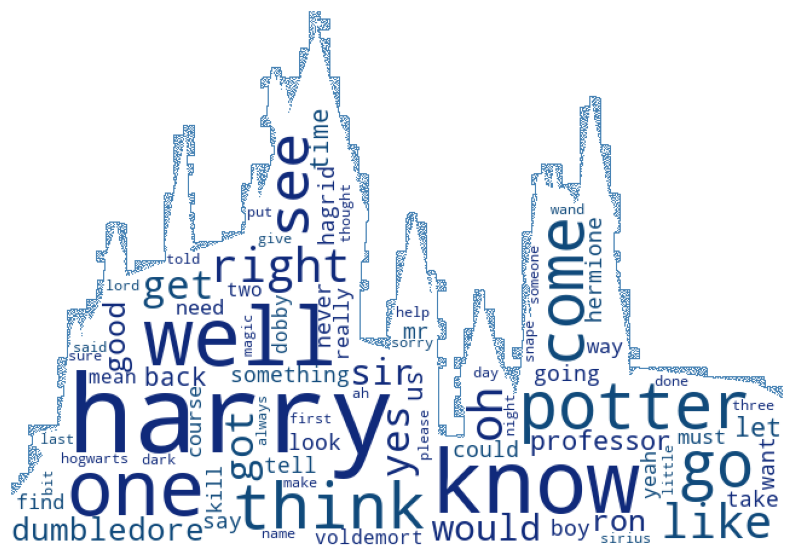

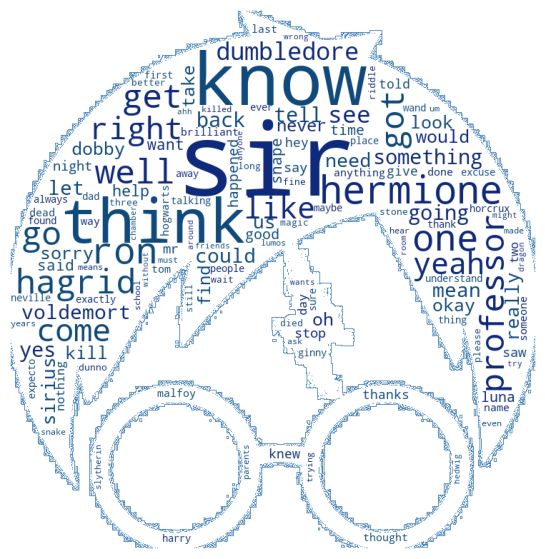

In [49]:
#### Analyse
### Worthäufigkeiten

## über alle Filme 
dialoge = df_ChDiCp['Tokens']
dialoge

# Worthäufigkeiten zählen
fdist = FreqDist()
for line in dialoge:
    for word in line:
        # wenn Wort vorkommt in FreqDist erhöhen
        fdist[word] +=1        
freqGesamt = fdist
freqG = freqGesamt.most_common(5) # 5 häufigsten  Wörter
print('5 häufigste Wörter über alle Filme: ', freqG)


## nur für Harry über alle Filme
# Harry Dialoge herausfiltern
df_dialHarry = df_ChDiCp[df_ChDiCp['Character ID'] == 1]

# Worthäufigkeiten zählen
fdistH = FreqDist()
for line in df_dialHarry['Tokens']:
    for word in line:
         fdistH[word] +=1        
commonwords_freq = fdistH
freqH = commonwords_freq.most_common(5)
freqH
print('5 häufigste Wörter von Harry: ',freqH)


## Darstellung als Wordcloud
# Masken bauen
mask = np.array(photo1)
#plt.imshow(photo1) # Bild anzeigen
maskharry = np.array(photo2)
#plt.imshow(photo2) # Bild anzeigen

# Farben anpassen
colorslist = ['#102A7B', '#104A7B']  # https:\\htmlcolorcodes.com
ColorMap = matplotlib.colors.ListedColormap(colorslist)


## WordCloud bilden
# über alle Filme
word_cloud = WordCloud(mask = mask, background_color= 'white',contour_width = 0.01,contour_color = 'steelblue', colormap = ColorMap, min_font_size=10).generate_from_frequencies(freqGesamt)
plt.figure(figsize = (15,7))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

# für Harry
word_cloud = WordCloud(mask = maskharry, background_color='white',contour_width = 0.01,contour_color = 'steelblue',colormap = ColorMap, min_font_size=10).generate_from_frequencies(commonwords_freq)
plt.figure(figsize=(15,7))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

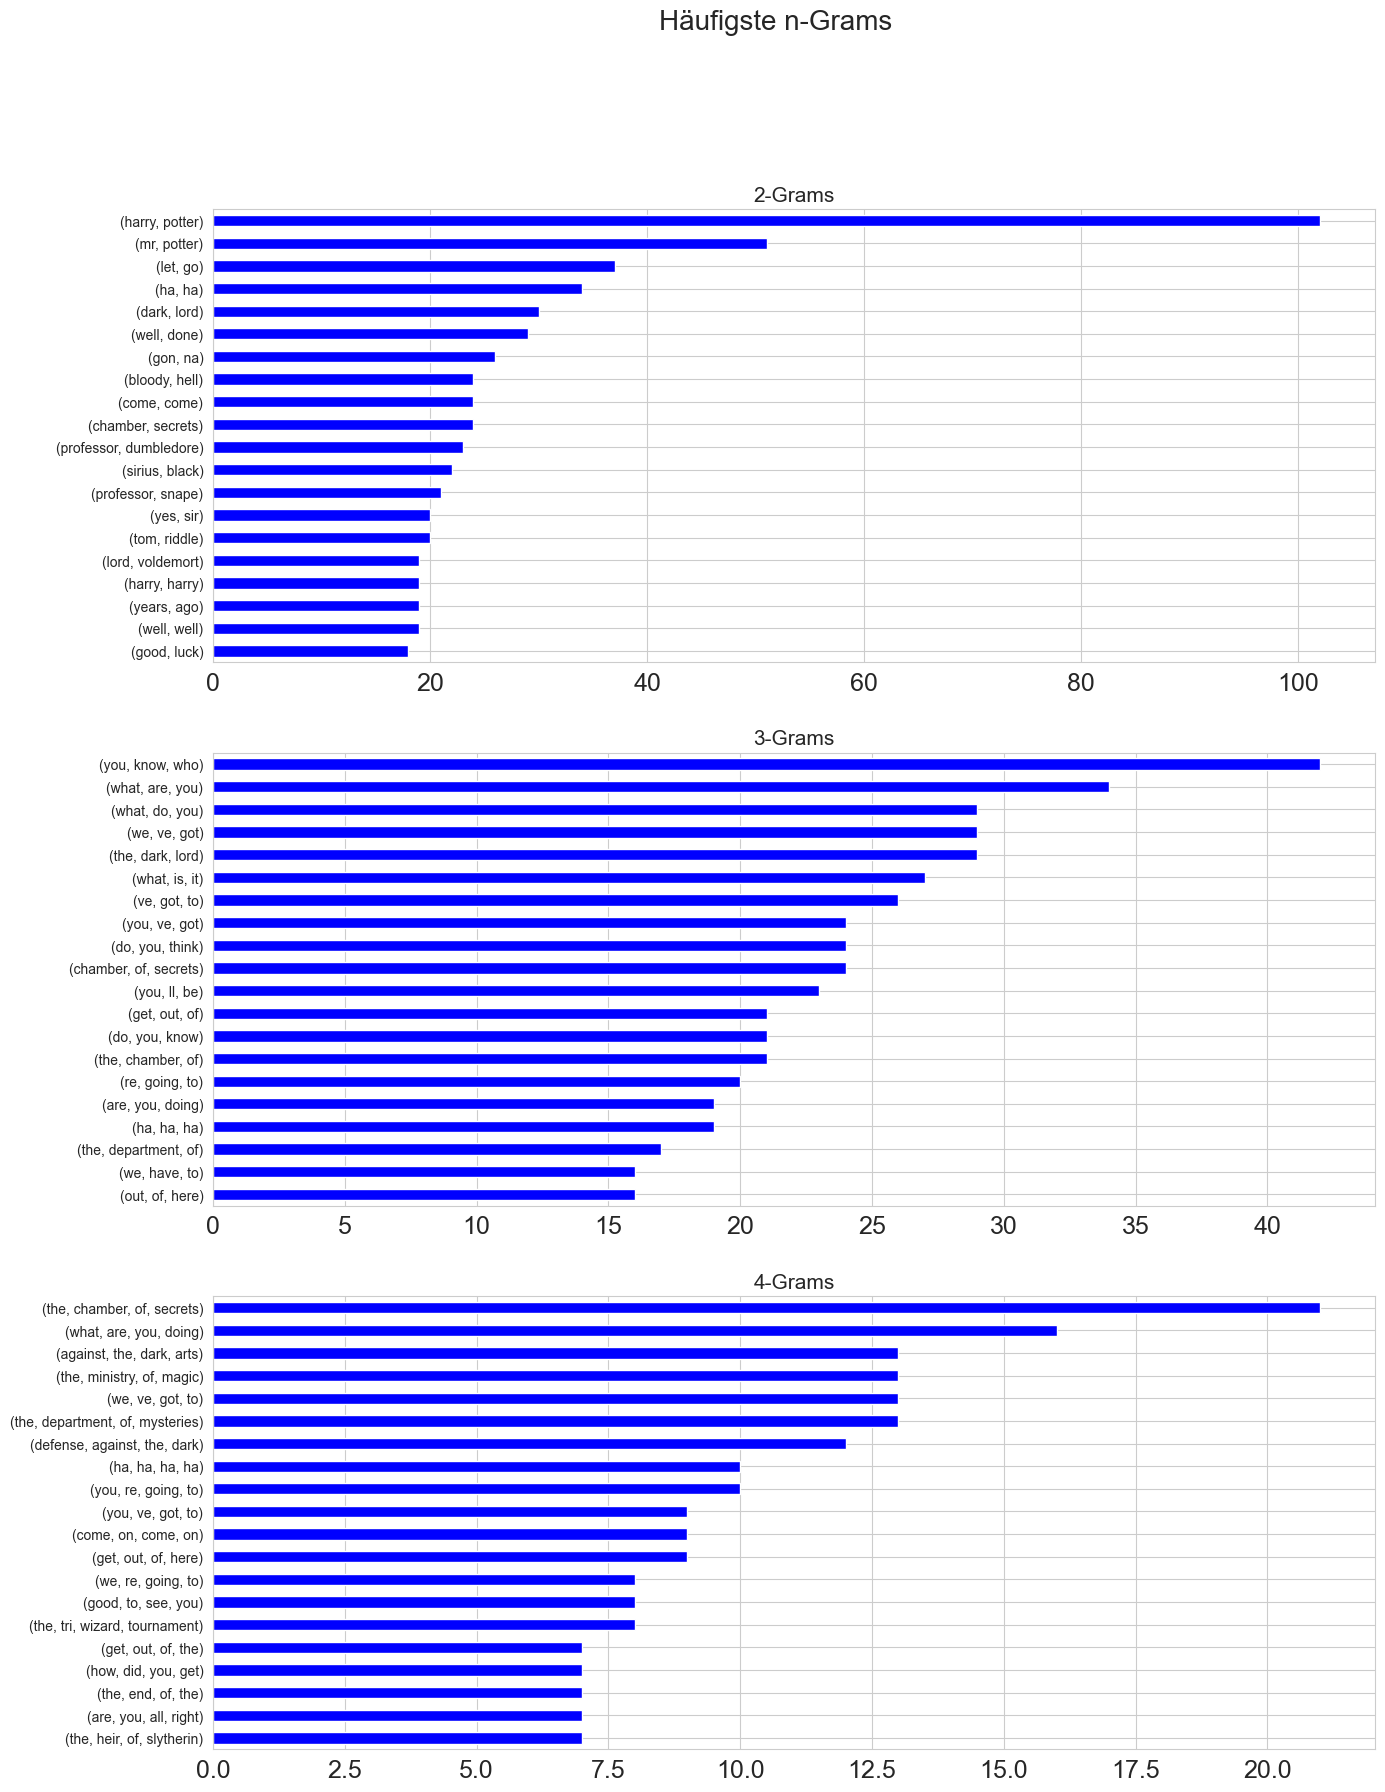

In [50]:
#### Analyse
## N-Grams über alle Filme

## Bi-Grams
dialoge = df_ChDiCp['Tokens']
dialoge.tolist()

# alle 2-Wort-Paare bilden pro Zeile
biGram = []
for line in dialoge:
    biGram.append(ngrams(line, 2))

#Zählt die Häufigkeit der Bi-Grams
fdist = FreqDist()
for line in biGram:
    for word in line:
        fdist[word] +=1 
nGram_freq2 = fdist
# 20 häufigsten Bi-Grams
all_fdist2 = FreqDist(nGram_freq2).most_common(20) 
all_fdist2 = pd.Series(dict(all_fdist2))
# print(all_fdist2) # Ausgabe der Series


## Tri-Grams
dialoge = df_ChDiCp['Tokens_Gensim']
dialoge.tolist()

# alle 3-Wort-Paare bilden pro Zeile
triGram = []
for line in dialoge:
    triGram.append(ngrams(line, 3))
triGram

#Zählt die Häufigkeit der Tri-Grams
fdist = FreqDist()
for line in triGram:
    for word in line:
        fdist[word] +=1 
triGram_freq3 = fdist
# 20 häufigsten Tri-Grams
all_fdist3 = FreqDist(triGram_freq3).most_common(20) 
all_fdist3 = pd.Series(dict(all_fdist3))
# print(all_fdist3) # Ausgabe der Series


## Quad-Grams
dialoge = df_ChDiCp['Tokens_Gensim']
dialoge.tolist()

# alle 4-Wort-Paare bilden pro Zeile
quadGram = []
for line in dialoge:
    quadGram.append(ngrams(line, 4))
quadGram

# Zählt die Häufigkeit der Quad-Grams
fdist = FreqDist()
for line in quadGram:
    for word in line:
        fdist[word] +=1 
quadGram_freq4 = fdist
# 20 häufigsten Quad-Grams
all_fdist4 = FreqDist(quadGram_freq4).most_common(20)
all_fdist4 = pd.Series(dict(all_fdist4))
# print(all_fdist4) # Ausgabe der Series



## Grafik erstellen
all_fdist = [all_fdist2, all_fdist3, all_fdist4] 

plt.figure(figsize =(15,20))
# Subplots erstellen
for i in range(1,4):
    plt.subplot(3,1,i)
    all_fdist[i-1].sort_values(ascending = True).plot(kind='barh', color = "Blue")
    plt.title(str(i+1)+ '-Grams', fontsize = 15) 

plt.suptitle('Häufigste n-Grams', fontsize = 20) 
plt.rc('ytick', labelsize = 15)
plt.show()


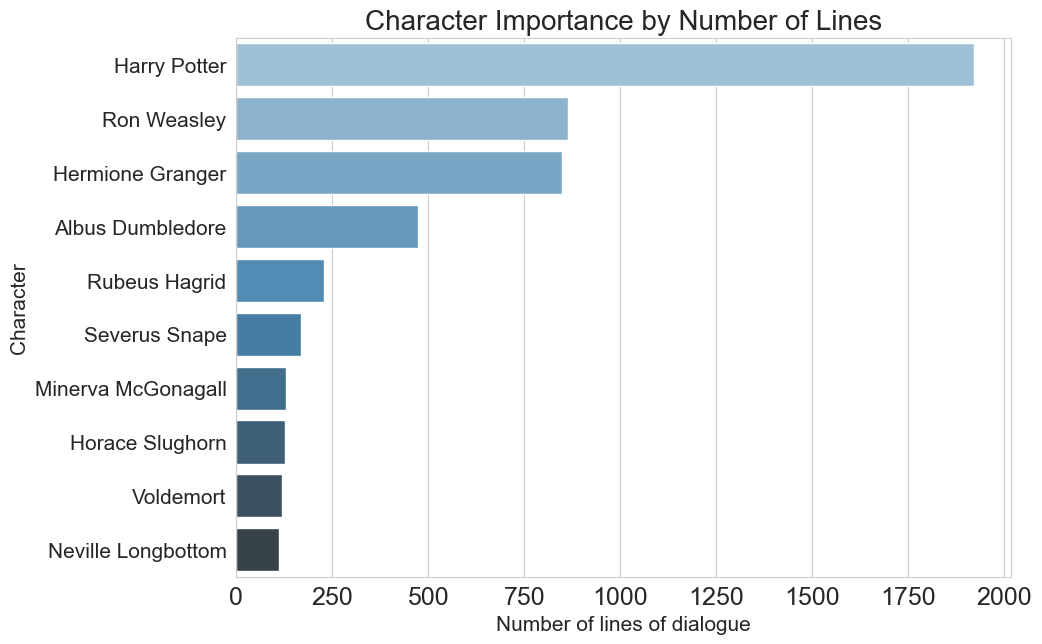

C:\Users\ACG\AppData\Local\Temp\ipykernel_17628\2248397167.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sns.barplot(x = 'wordcount', y ='CharacterName', data = totalword, palette = 'Blues_d', order = totalword.sort_values('wordcount',ascending = False).CharacterName[0:10], orient= 'h')


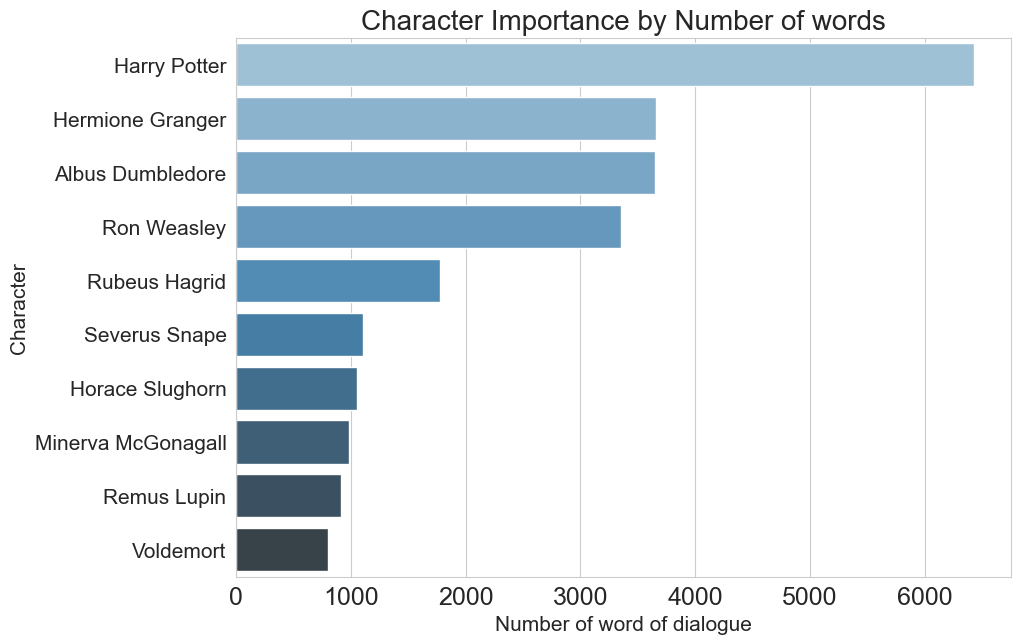

In [51]:
#### Analyse
### Redeanteile

## Redeanteile der Charaktere pro Dialog berechnen
charaktere = df_ChDiCp['Character Name'].value_counts()
# print(charaktere) # Ausgabe


## Grafik erstellen
sns.set_style('whitegrid')
plt.figure(figsize= (10,7))
sns.countplot(y ='Character Name', data = df_ChDiCp, palette= 'Blues_d', order = charaktere.iloc[:10].index)
plt.xlabel('Number of lines of dialogue', fontsize = 15)
plt.ylabel('Character', fontsize = 15)
plt.title('Character Importance by Number of Lines', fontsize = 20)
plt.show()



## Redeanteil der Charaktere pro Wort

dialoge = df_ChDiCp['Tokens']

# Zählt Wörter pro Zeile 
wordcount = []
for line in dialoge:
    wordcount.append(len(line))
wordcount

# weist jeder Zeile sein Wordcount zu
df_ChDiCp['wordcount'] = wordcount
df_ChDiCp

# geht jeden Charakter durch und summiert die Spalte wordcount auf und speichert als DataFrame
totalword = df_ChDiCp.groupby('Character Name', as_index= False).wordcount.sum()
totalword = totalword.rename(columns ={ totalword.columns[0]: 'CharacterName'})
totalword

## Grafik
sns.set_style('whitegrid')
plt.figure(figsize= (10,7))
sns.barplot(x = 'wordcount', y ='CharacterName', data = totalword, palette = 'Blues_d', order = totalword.sort_values('wordcount',ascending = False).CharacterName[0:10], orient= 'h') 
plt.xlabel('Number of word of dialogue', fontsize = 15) 
plt.ylabel('Character', fontsize = 15)
plt.title('Character Importance by Number of words', fontsize = 20)
plt.show()

Gryffindor                      5369
Slytherin                        860
Ravenclaw                        222
Hufflepuff                        56
Beauxbatons Academy of Magic      15
Durmstrang Institute               5
Name: House, dtype: int64


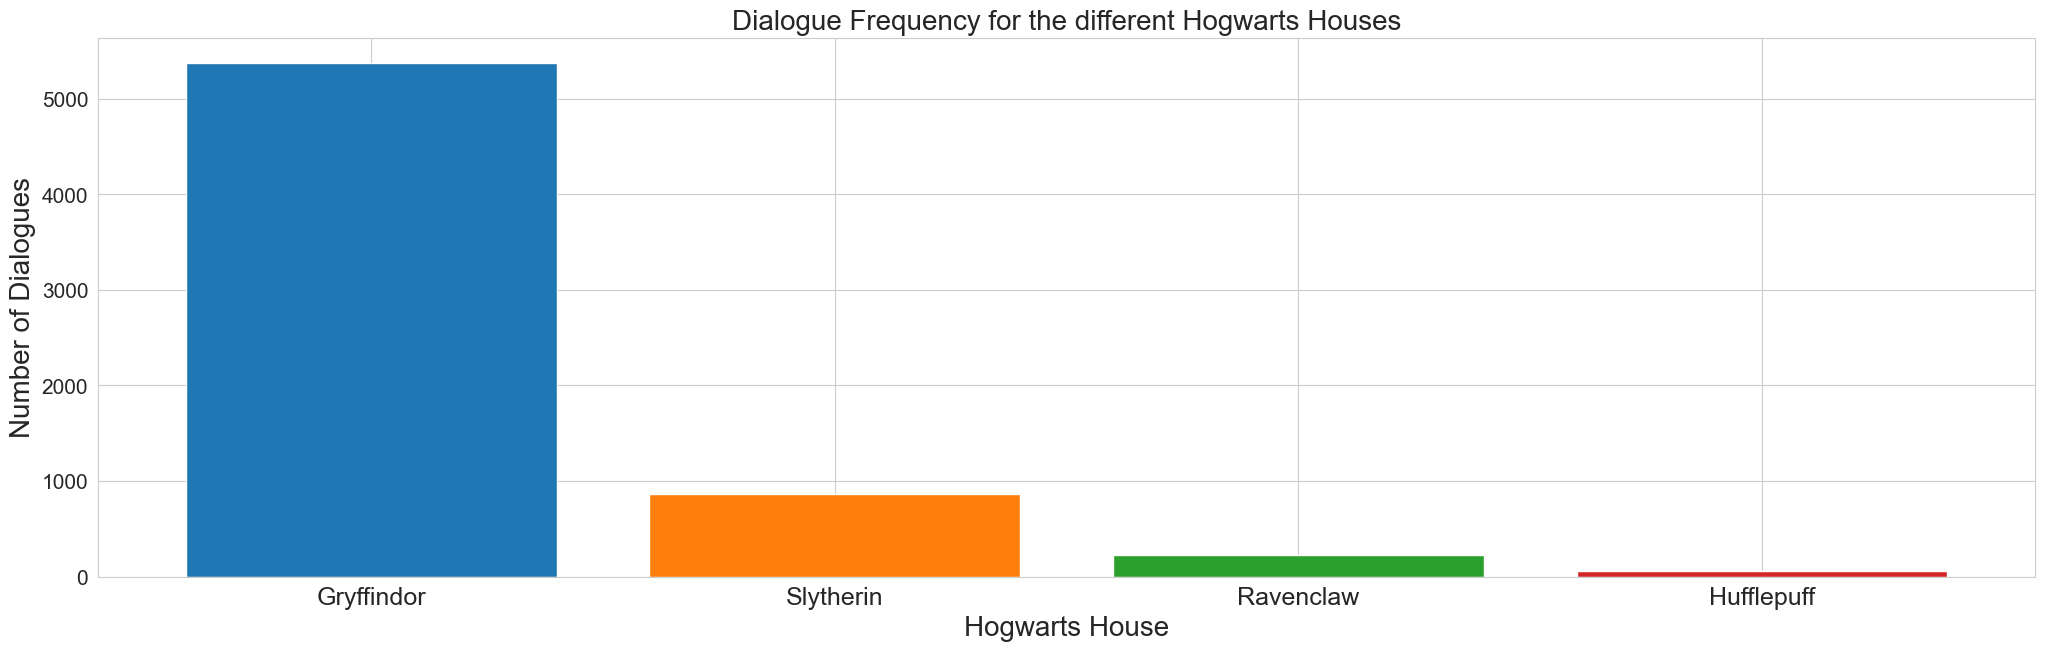

In [52]:
#### Analyse
### Dialoge pro Haus für alle Filme

# Zeilen pro Haus zählen
counts = df_ChDiCp['House'].value_counts()
print(counts)
# nur die Hogwarts Häuser
top_talkative_houses = counts[:4]

## Grafik erstellen
plt.figure(figsize=(25, 7))

#Säulen erstellen
for character_id, count in top_talkative_houses.items():
    plt.bar(character_id, count)

plt.xlabel('Hogwarts House', fontsize = 20)
plt.ylabel('Number of Dialogues', fontsize = 20)
plt.title('Dialogue Frequency for the different Hogwarts Houses', fontsize = 20)
plt.rc('xtick', labelsize = 16)
plt.rc('ytick', labelsize = 10)
plt.show()

[]                    7312
[expelliarmus]          12
[expecto patronum]      12
[lumos]                  9
[riddikulus]             8
[accio]                  6
[alohomora]              5
[stupefy]                4
[impedimenta]            4
[confringo]              4
Name: spell_count, dtype: int64


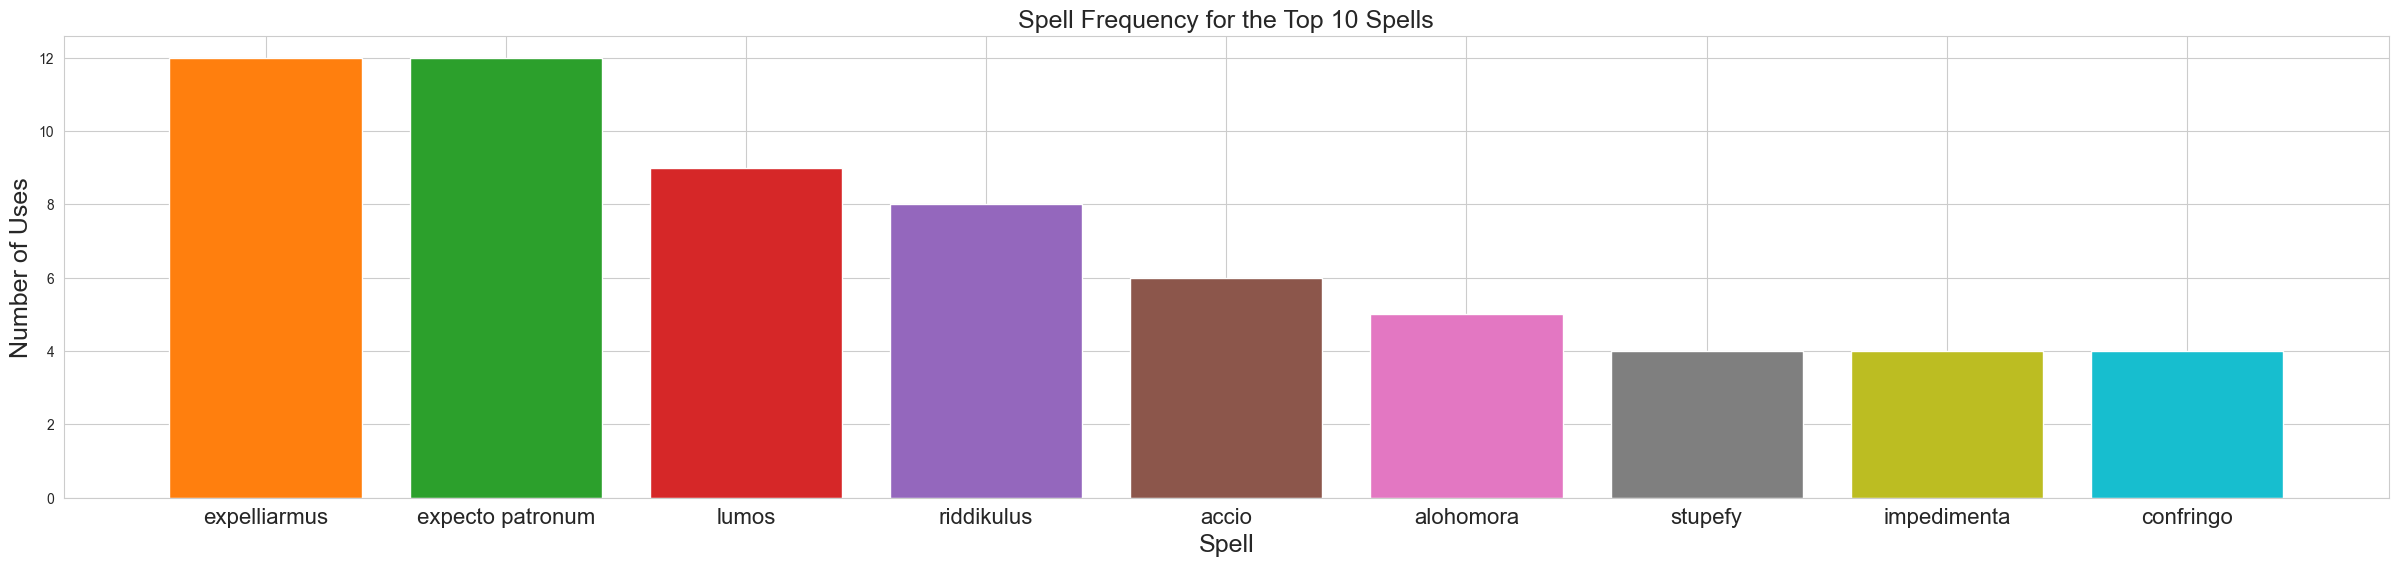

In [53]:
#### Analyse
### Spells

# Vorbereitung: Kleinschreibung und als Liste herausgreifen
spells = df_spells['Incantation'].str.lower().to_list()
spells

# Prüft, ob ein Dialog (d.h. Zeile) einen Zauberspruch enthält
def count_spells_1and2words(row, spells):
    used_spells = []
    for spell in spells:
        if ' ' in spell:
            # Prüft, ob ein 2-Wort-Zauberspruch als Ganzes erscheint
            if spell in ' '.join(row):
                used_spells.append(spell)
        else:
            # Prüft, ob ein 1-Wort Zauberspruch als Ganzes erscheint
            if spell in row:
                used_spells.append(spell)
    return used_spells

# Funktionsaufruf count_spells_1and2words pro Zeile des df_ChDiCp
df_ChDiCp['spell_count'] = df_ChDiCp['Tokens'].apply(count_spells_1and2words, spells=spells)

# DataFrame erstellen
spell_counts = df_ChDiCp['spell_count'].value_counts()

# Top 10 Spells in allen Filmen
counts = df_ChDiCp['spell_count'].value_counts()
most_used_spells = counts[:10]
print(most_used_spells)



## Grafik erstellen
plt.figure(figsize=(30, 6))

# Säulen erstellen
for spell_name, count in most_used_spells.items():
    plt.bar(spell_name, count)

plt.xlabel('Spell', fontsize = 18)
plt.ylabel('Number of Uses', fontsize = 18)
plt.title('Spell Frequency for the Top 10 Spells', fontsize = 18)
plt.rc('xtick', labelsize = 18)
plt.rc('ytick', labelsize = 17)
plt.show()

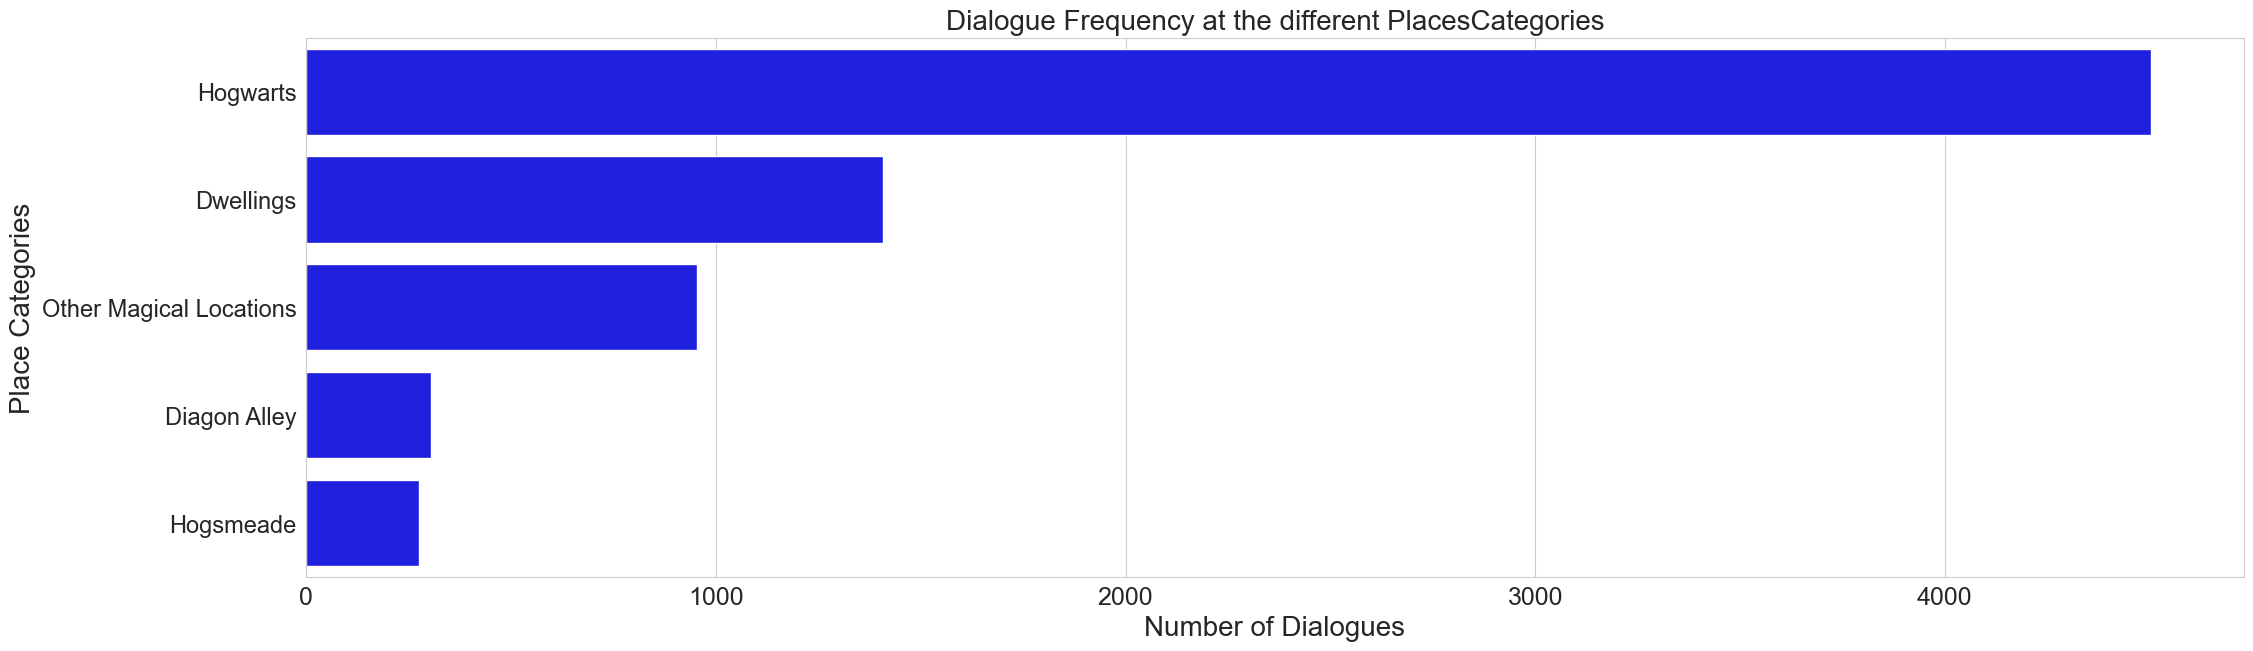

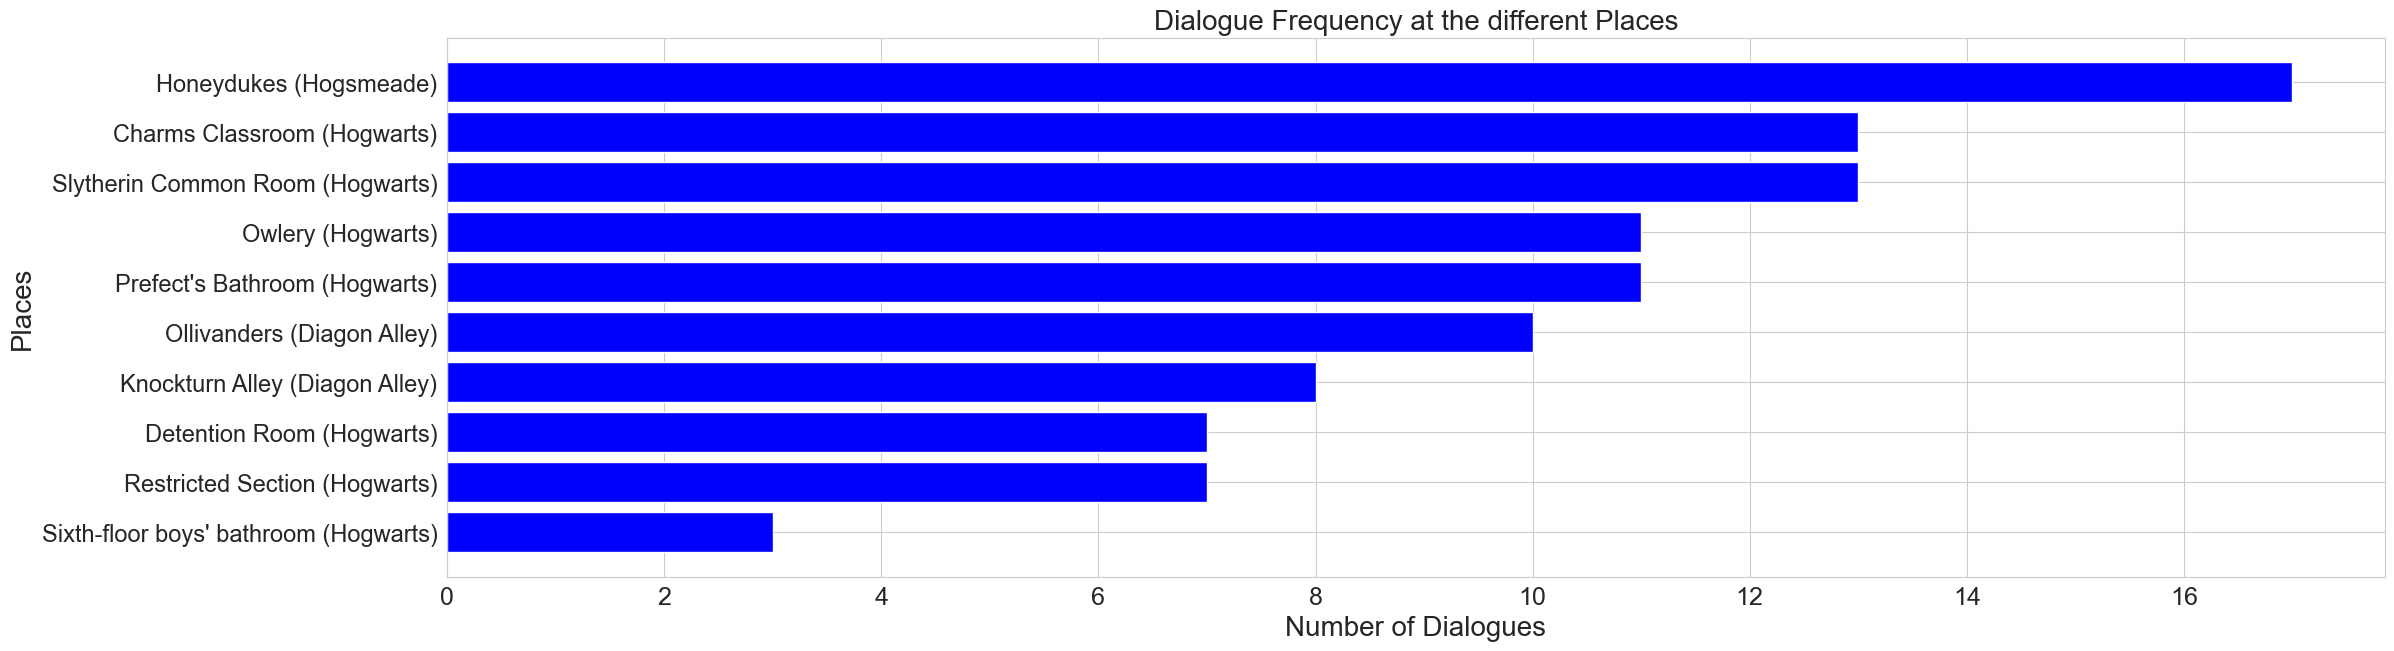

In [54]:
#### Analyse
## Betrachtung Places

places = df_places['Place Name']

# Jeden Platz zählen
place_count = df_ChDiCp['Place ID'].value_counts()
place_count

# Abspeichern als Data Frame
places_counts = pd.DataFrame(place_count)
places_counts = places_counts.reset_index().rename(columns={'index': 'PlaceID', 'Place ID': 'Counts'}).sort_values(by= ['PlaceID'], ascending = True).reset_index()
places_counts['PlaceName'] = df_places['Place Name']
places_counts['PlaceCategory'] = df_places['Place Category']
places_counts = places_counts.loc[:,['PlaceID', 'PlaceName', 'PlaceCategory', 'Counts']]
places_counts

# top 10 Plätze
top_places = places_counts.sort_values(by= ['Counts'], ascending = True).iloc[:10]
top_places

# Paltzkategorie zusammenfassen und zählen
category = places_counts.groupby('PlaceCategory').Counts.sum().reset_index().sort_values('Counts', ascending = False)
category


## Grafik erstellen für PlaceCategory
plt.figure(figsize=(25, 7))
sns.barplot(x= 'Counts', y= 'PlaceCategory', data = category, orient = 'h', color = 'Blue')
plt.xlabel('Number of Dialogues', fontsize = 20)
plt.ylabel('Place Categories', fontsize = 20) 
plt.title('Dialogue Frequency at the different PlacesCategories', fontsize = 20)
plt.show()



## Grafik erstellen für top 10 PLätze
x = top_places['Counts'].tolist()
y = top_places['PlaceName'].map(str) + ' (' + top_places['PlaceCategory'].map(str) + ')'

plt.figure(figsize=(25, 7))
plt.barh(y,x, color = "Blue")
plt.xlabel('Number of Dialogues', fontsize = 20)
plt.ylabel('Places', fontsize = 20)
plt.title('Dialogue Frequency at the different Places', fontsize = 20)
plt.show()


In [55]:
#### Sentiment Analyse ####

# Lexikon
sentiment = nltk.sentiment.vader.SentimentIntensityAnalyzer()
#print(sentiment.lexicon) # Lexikon ausgeben

### SentimentAnalyse über ganzen DataFrame
scores = df_ChDiCp.Dialogue.apply(lambda x: sentiment.polarity_scores(x))
scores

# in Data Frame df_ChDiCp integrieren und aufteilen
df_ChDiCp['SentimentScore'] = scores
df_ChDiCp['CompScore'] = df_ChDiCp.SentimentScore.apply(lambda x: x.get('compound'))
df_ChDiCp['PosScore'] = df_ChDiCp.SentimentScore.apply(lambda x: x.get('pos'))
df_ChDiCp['NegScore'] = df_ChDiCp.SentimentScore.apply(lambda x: x.get('neg'))
df_ChDiCp['NeuScore'] = df_ChDiCp.SentimentScore.apply(lambda x: x.get('neu'))
df_ChDiCp

Dialogue ID  Chapter ID  Place ID  Character ID  \
0               1           1         8             4   
1               2           1         8             7   
2               3           1         8             4   
3               4           1         8             7   
4               5           1         8             4   
...           ...         ...       ...           ...   
7439         7440         234        71             1   
7440         7441         234        71            84   
7441         7442         234        71             1   
7442         7443         234        71             1   
7443         7444         234        71            84   

                                               Dialogue      Character Name  \
0     I should have known that you would be here...P...    Albus Dumbledore   
1     Good evening, Professor Dumbledore. Are the ru...  Minerva McGonagall   
2      I'm afraid so, Professor. The good, and the bad.    Albus Dumbledore   
3                                          And the boy?  Minerva McGonagall   
4                               Hagrid is bringing him.    Albus Dumbledore   
...                                                 ...                 ...   
7439  Then Slytherin House will have gained a wonder...        Harry Potter   
7440                                            Really?        Albus Potter   
7441                                            Really.        Harry Potter   
7442                                             Ready?        Harry Potter   
7443                                             Ready.        Albus Potter   

     Species  Gender       House Patronus  ...  \
0      Human    Male  Gryffindor  Phoenix  ...   
1      Human  Female  Gryffindor      Cat  ...   
2      Human    Male  Gryffindor  Phoenix  ...   
3      Human  Female  Gryffindor      Cat  ...   
4      Human    Male  Gryffindor  Phoenix  ...   
...      ...     ...         ...      ...  ...   
7439   Human    Male  Gryffindor     Stag  ...   
7440   Human    Male   Slytherin      NaN  ...   
7441   Human    Male  Gryffindor     Stag  ...   
7442   Human    Male  Gryffindor     Stag  ...   
7443   Human    Male   Slytherin      NaN  ...   

                                               pos_tags  \
0     [(should, MD), (have, VB), (known, VBN), (that...   
1     [(good, JJ), (evening, NN), (professor, NN), (...   
2     [(afraid, NNS), (so, RB), (professor, IN), (th...   
3                     [(and, CC), (the, DT), (boy, NN)]   
4     [(hagrid, NN), (is, VBZ), (bringing, VBG), (hi...   
...                                                 ...   
7439  [(then, RB), (slytherin, NN), (house, NN), (wi...   
7440                                     [(really, RB)]   
7441                                     [(really, RB)]   
7442                                      [(ready, JJ)]   
7443                                      [(ready, JJ)]   

                                                 chunks  \
0     [(should, MD), (have, VB), (known, VBN), (that...   
1     [(good, JJ), (evening, NN), (professor, NN), (...   
2     [(afraid, NNS), (so, RB), (professor, IN), (th...   
3                     [(and, CC), (the, DT), (boy, NN)]   
4     [(hagrid, NN), (is, VBZ), (bringing, VBG), (hi...   
...                                                 ...   
7439  [(then, RB), (slytherin, NN), (house, NN), (wi...   
7440                                     [(really, RB)]   
7441                                     [(really, RB)]   
7442                                      [(ready, JJ)]   
7443                                      [(ready, JJ)]   

                                all_entities_spacy_dial  wordcount  \
0                                [(McGonagall, PERSON)]          4   
1     [(evening, TIME), (Dumbledore, PERSON), (Albus...          7   
2                                                    []          4   
3                                                    []          1   
4  

Sedimentscore über alle Filme:  0.04129742074153681
   Movie ID                                         Film  CompScore
0         1     Harry Potter and the Philosopher's Stone   0.049670
1         2      Harry Potter and the Chamber of Secrets   0.032011
2         3     Harry Potter and the Prisoner of Azkaban   0.044817
3         4          Harry Potter and the Goblet of Fire   0.053468
4         5    Harry Potter and the Order of the Phoenix   0.022308
5         6       Harry Potter and the Half-Blood Prince   0.081727
6         7  Harry Potter and the Deathly Hallows Part 1   0.031678
7         8  Harry Potter and the Deathly Hallows Part 2   0.010502


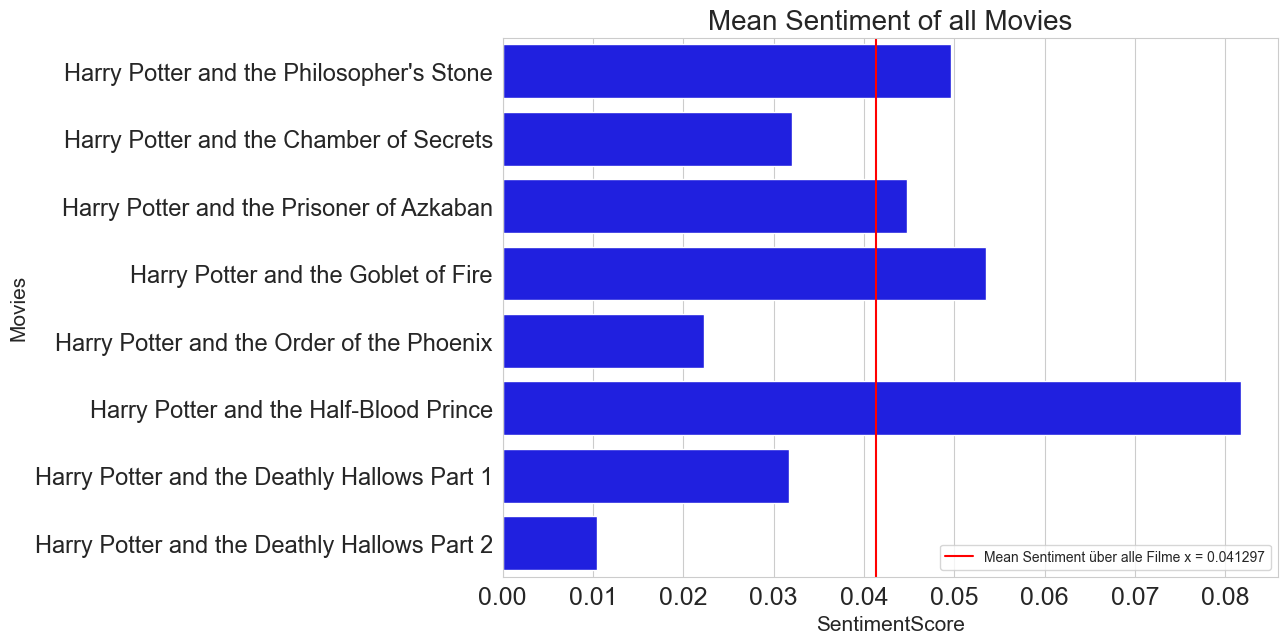

In [56]:
#### Sentiment Analyse
### Sedimentscore über alle Filme gesamt
# Idee: Mittelwert der Compscore

score = df_ChDiCp['CompScore'].mean()
print('Sedimentscore über alle Filme: ',score)
#=0.04129742074153681

## Sedimentscore über jeden Film einzelnd
# Idee: Mittelwert der CompScore
sentiment_film = df_ChDiCp.groupby('Movie ID', as_index =False).CompScore.mean()
sentiment_film['Film'] = Movie['Movie Title']
sentiment_film = sentiment_film.loc[:,['Movie ID', 'Film', 'CompScore']]
print(sentiment_film)


## Grafik erstellen
sns.set_style('whitegrid')
plt.figure(figsize= (10,7))
sns.barplot(x = 'CompScore' ,y ='Film', data = sentiment_film, color='blue')
plt.xlabel('SentimentScore', fontsize = 15)
plt.ylabel('Movies', fontsize = 15)
plt.title('Mean Sentiment of all Movies', fontsize = 20)
plt.axvline(x= score, color = 'red',label = f'Mean Sentiment über alle Filme x = {round(score,6)}')
plt.rc('ytick', labelsize = 13)
plt.legend()
plt.show()


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

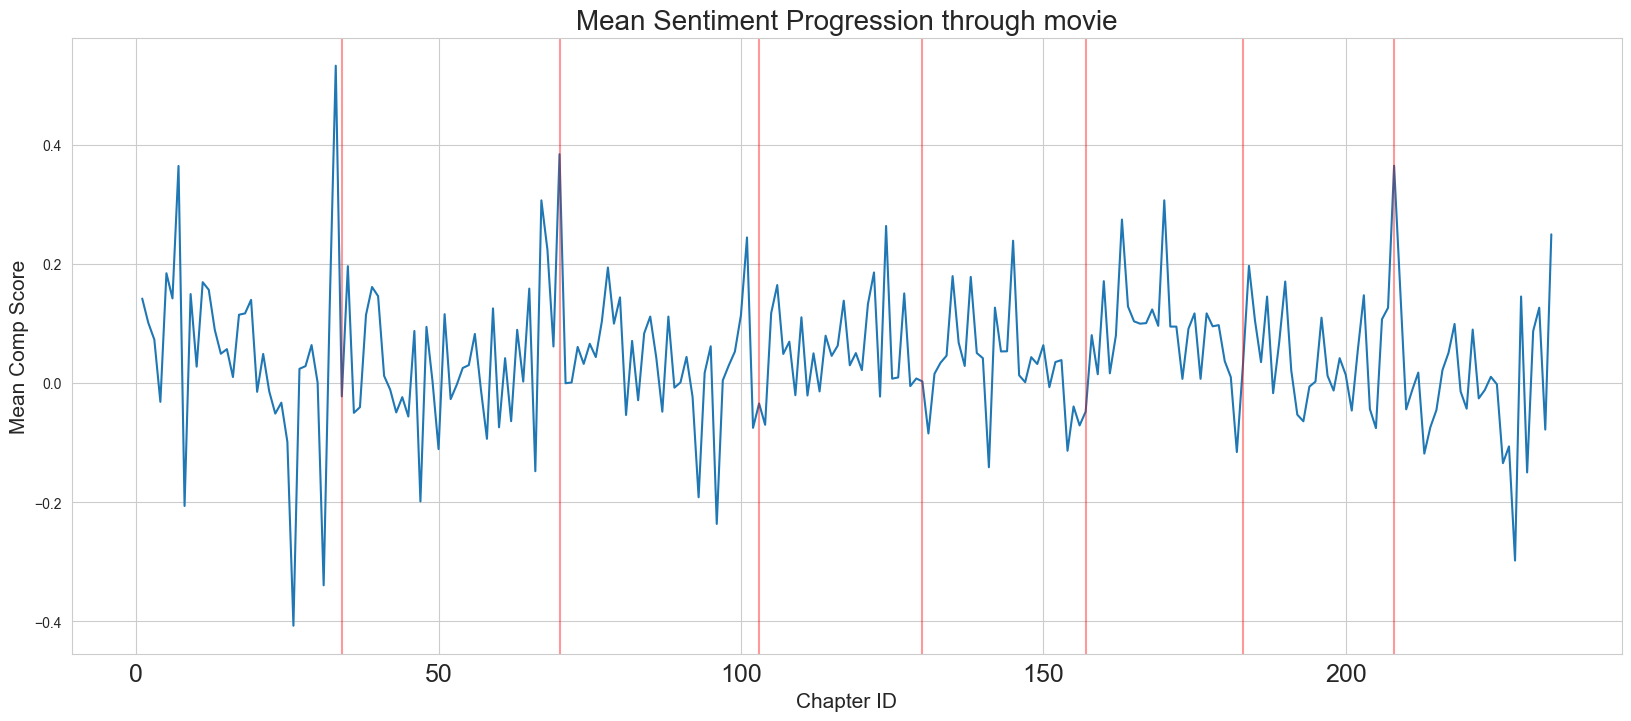

In [69]:
#### Sentiment Analyse
# Idee: Mittelwert der CompScore

### Sentimentverlauf über die Kapitel

## Sedimentscore für jedes Kapitel
sentimentchapter = pd.DataFrame(df_ChDiCp.groupby('Chapter ID', as_index = False).CompScore.mean())
sentimentchapter

## Grafik erstellen
sns.set_style('whitegrid')
plt.figure(figsize= (20,8))
sns.lineplot(x= 'Chapter ID' ,y ='CompScore', data = sentimentchapter)
plt.xlabel('Chapter ID', fontsize = 15)
plt.ylabel('Mean Comp Score', fontsize = 15)
plt.title('Mean Sentiment Progression through movie', fontsize = 20) 

#Kapitelgrenzen, die vorher herausgefiltert wurden, als rote Linie einzeichnen (=[34,70,103,130,157,183,208])
for x in Filmgrenzen[:7]:
    plt.axvline(x=x, color = 'red', alpha = 0.4, label = f'Filmende Kapitel = {x}') 
plt.axhline(y=score, color = 'orange', alpha = 0.9, label = 'gesamte Sentimentscore') #-> soll ich das einfügen
plt.legend()
plt.rc('ytick', labelsize = 15)
plt.show()


          CharacterName  CompScore
0         Alastor Moody   0.004629
1      Albus Dumbledore   0.110305
2        Arthur Weasley   0.073210
3   Bellatrix Lestrange   0.076673
4       Cornelius Fudge   0.054630
5      Dolores Umbridge   0.048452
6          Draco Malfoy   0.029168
7          Fred Weasley   0.079985
8        George Weasley   0.086532
9         Ginny Weasley   0.019049
10         Harry Potter   0.012939
11     Hermione Granger   0.015623
12      Horace Slughorn   0.172944
13        Lucius Malfoy   0.093627
14        Luna Lovegood   0.008847
15   Minerva McGonagall   0.116254
16   Neville Longbottom   0.021105
17          Remus Lupin   0.146508
18          Ron Weasley  -0.015959
19        Rubeus Hagrid   0.038213
20        Severus Snape   0.086514
21         Sirius Black  -0.018827
22           Tom Riddle   0.032677
23       Vernon Dursley   0.000218
24            Voldemort  -0.004114


C:\Users\ACG\AppData\Local\Temp\ipykernel_17628\1523293396.py:31: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sns.barplot(x= 'CompScore' ,y ='CharacterName', data = sentiment_characters, order = sentiment_characters.sort_values('CompScore', ascending =False).CharacterName[0:25], color='blue')


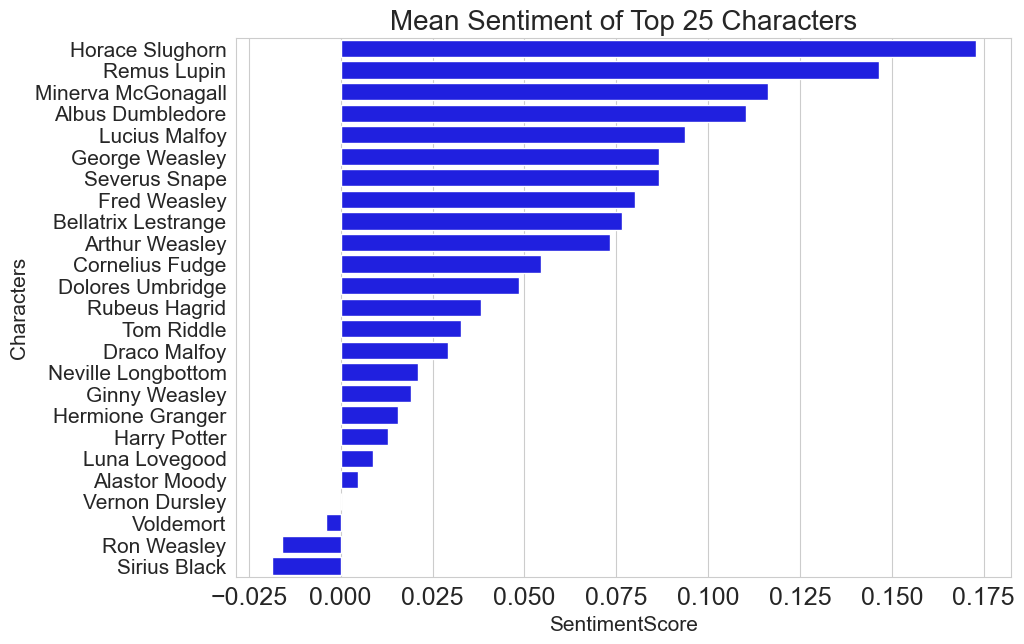

In [58]:
#### Sentiment Analyse
### Sentimentscore von allen Charakteren einzelnd

# für jeden Charakter Dialoganzahl berechnen
filtered = df_ChDiCp
counts = filtered['Character Name'].value_counts() 
# auf Top 25 Charaktere eingrenzen
counts = counts[0:25] 

# als Data Fram darstellen
counts = pd.DataFrame(counts)
counts['Count'] =counts['Character Name']
counts['Character Name']= counts.index
counts = counts.reset_index()
counts = counts.drop('index',axis =1)
# print(counts)

# Dataa Frames vergleichen ob Top 25 Charaktere in filtered enthalten und nur diese Dialoge beibehalten
filtered = filtered[filtered['Character Name'].isin(counts['Character Name'])]
#print(filtered)

# pro Charakter der Mittelwert der CompScore
sentiment_characters = filtered.groupby('Character Name', as_index =False).CompScore.mean()
sentiment_characters = sentiment_characters.rename(columns ={ sentiment_characters.columns[0]: 'CharacterName'})
print(sentiment_characters)


## Grafik erstellen
sns.set_style('whitegrid') 
plt.figure(figsize= (10,7))
sns.barplot(x= 'CompScore' ,y ='CharacterName', data = sentiment_characters, order = sentiment_characters.sort_values('CompScore', ascending =False).CharacterName[0:25], color='blue')
plt.xlabel('SentimentScore', fontsize = 15)
plt.ylabel('Characters', fontsize = 15)
plt.title('Mean Sentiment of Top 25 Characters', fontsize = 20)
plt.rc('ytick', labelsize = 10)
plt.show()


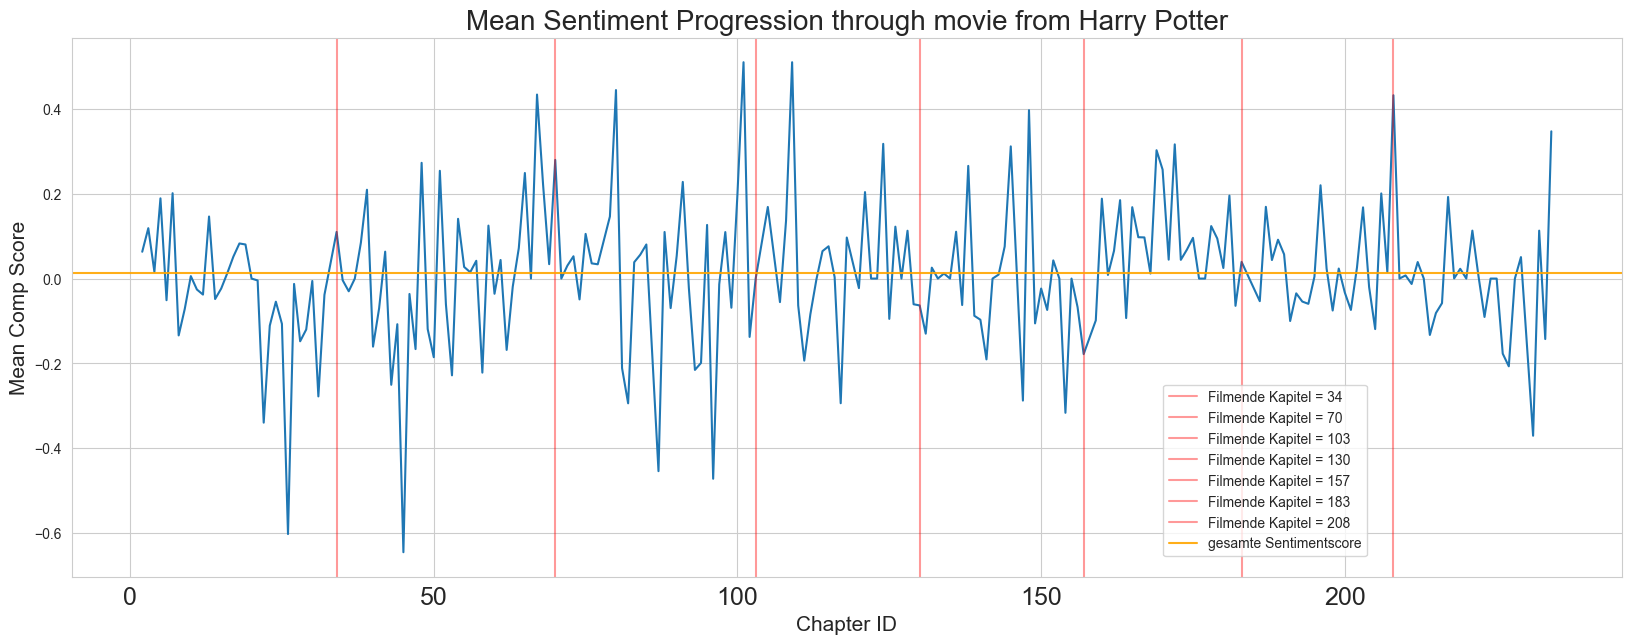

In [59]:
#### Sentiment Analyse
### SentimentAnalyse von Harry pro Chapter

# Dialoge von Harry
df_dialHarry = df_ChDiCp[df_ChDiCp['Character ID'] == 1]
df_dialHarry

# pro Kapitel Sentiment von Harry als Mittelwert
sentiment_harry = df_dialHarry.groupby('Chapter ID', as_index =False).CompScore.mean()
sentiment_harry

### Grafik erstellen
sns.set_style('whitegrid') 
plt.figure(figsize= (20,7))
sns.lineplot(x= 'Chapter ID' ,y ='CompScore', data = sentiment_harry)
plt.xlabel('Chapter ID', fontsize = 15)
plt.ylabel('Mean Comp Score', fontsize = 15) 
plt.title('Mean Sentiment Progression through movie from Harry Potter', fontsize = 20) 
#Filmgrenzen, die vorher mal herausgefiltert wurden, als rote Linie einzeichnen (=[34,70,103,130,157,183,208])
for x in Filmgrenzen[:7]:
    plt.axvline(x=x, color = 'red', alpha = 0.4, label = f'Filmende Kapitel = {x}')
meanharry = sentiment_characters[sentiment_characters["CharacterName"] == "Harry Potter"].CompScore
plt.axhline(y=meanharry.item(), color = "orange", alpha = 0.9, label = 'gesamte Sentimentscore') 
plt.legend(bbox_to_anchor = (0.84, 0.025)) 
plt.show()



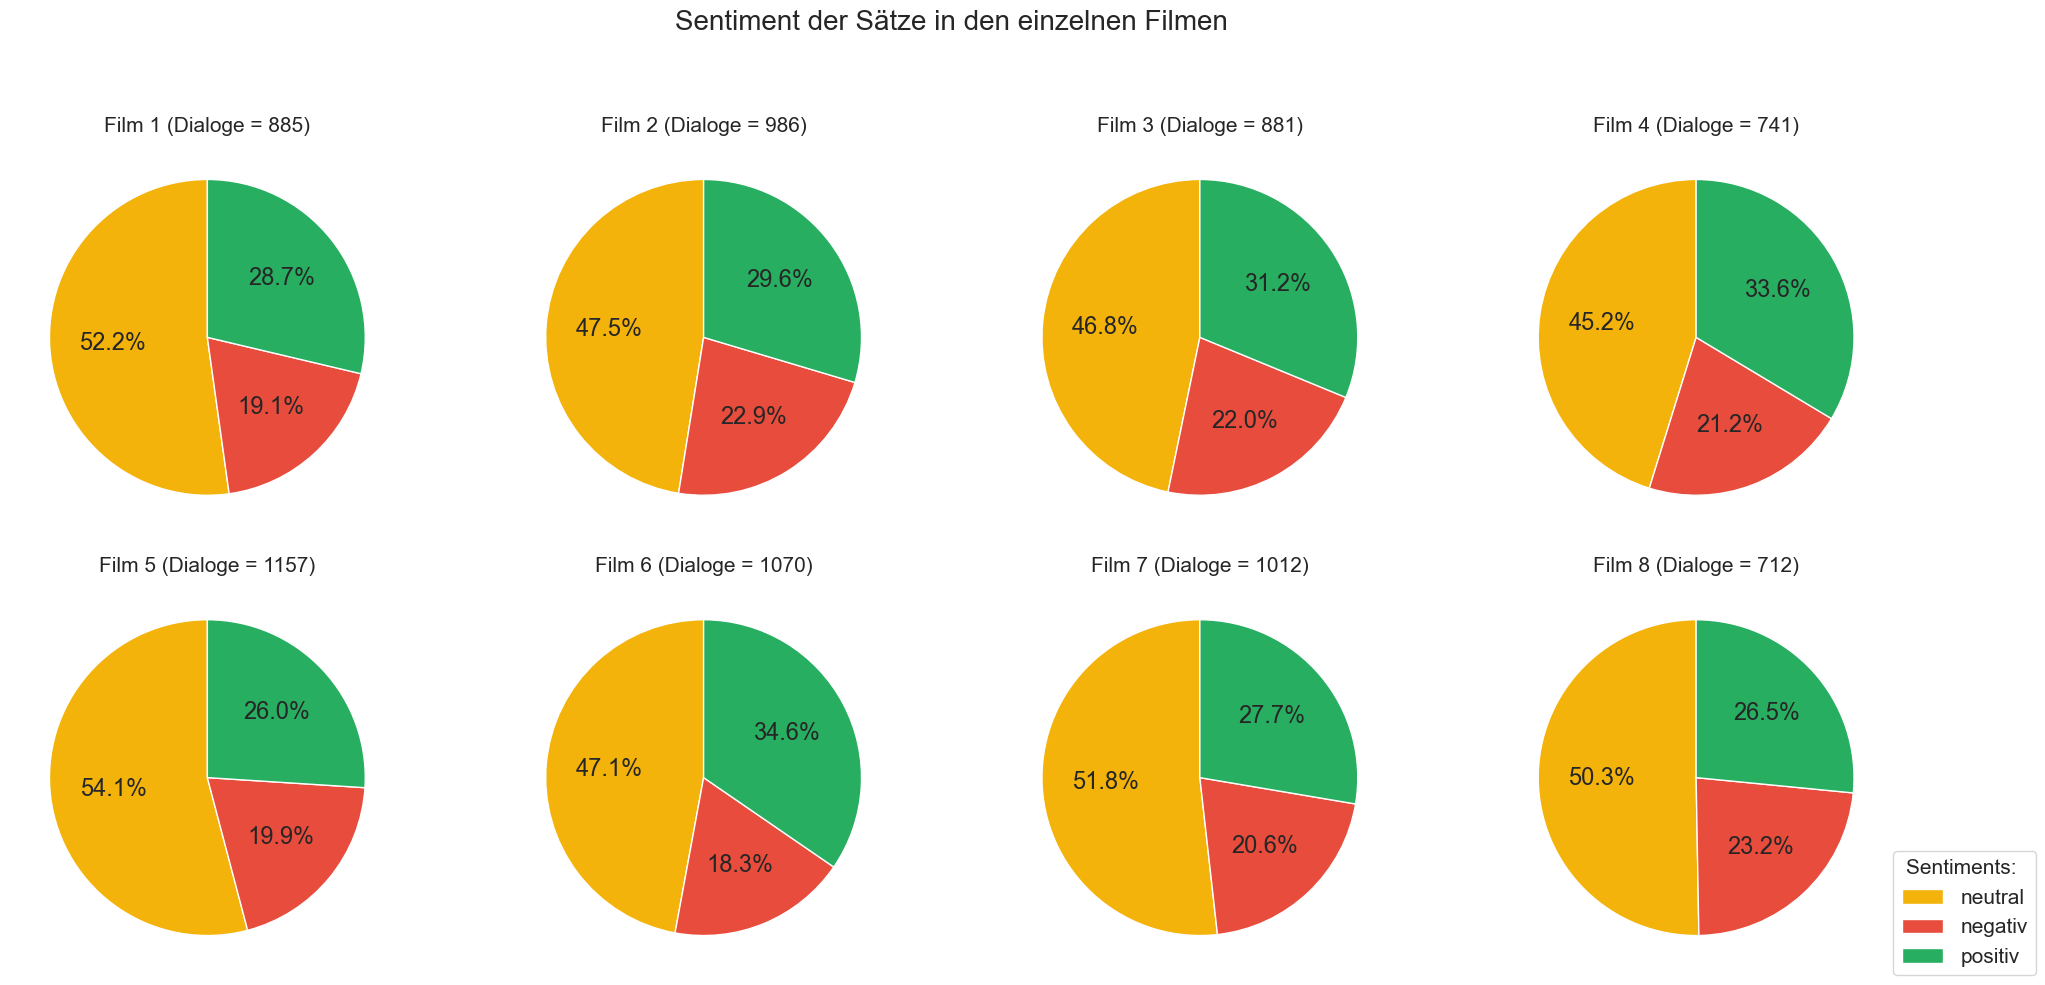

Text(0.5, 1.0, 'Sentiment der Sätze\n(Dialoge = 7444)')

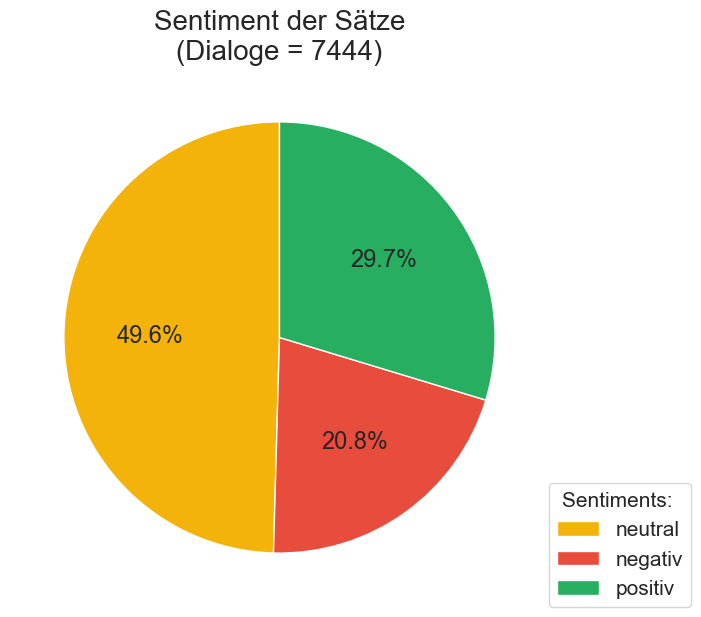

In [76]:
#### Sentiment Analyse
## Unterteilung Positiv, Negativ, Neutral für alle Filme

# Sentimentscore in Gruppen zusammenfügen
df_ChDiCp['PosFlag'] = df_ChDiCp.CompScore.apply(lambda x: 1 if x >= 0.05 else 0)
df_ChDiCp['NegFlag'] = df_ChDiCp.CompScore.apply(lambda x: 1 if x <= -0.05 else 0)
df_ChDiCp['NeuFlag'] = df_ChDiCp.CompScore.apply(lambda x: 1 if x < 0.05 and x > -0.05 else 0) 
df_ChDiCp

## Grafik erstellen für jeden Film einzelnd
sns.set_style('whitegrid') 
plt.figure(figsize=(20,10))

# Subplots darstellen
for i in Movie['Movie ID']:
    movie = df_ChDiCp[df_ChDiCp['Movie ID'] == i]
    #für jeden Film Sentiment aufsummieren
    AnzahlposSätze = movie['PosFlag'].sum()
    AnzahlnegSätze = movie['NegFlag'].sum()
    AnzahlneuSätze = movie['NeuFlag'].sum()

    # Daten und labels festlegen
    y = [AnzahlneuSätze,AnzahlnegSätze, AnzahlposSätze]
    x = ['neutral', 'negativ', 'positiv']

    plt.subplot(2,4,i)
    summe = AnzahlnegSätze+ AnzahlneuSätze + AnzahlposSätze
    plt.title(f'Film {i} (Dialoge = {summe})',  size = 15) 
    plt.pie(x= y, colors = ['#F3B30A','#E74C3C', '#27AE60'],autopct = '%1.1f%%', textprops = {'fontsize': 17}, startangle= 90.0) 
    

plt.tight_layout(h_pad = 3) 
plt.suptitle('Sentiment der Sätze in den einzelnen Filmen', fontsize = 20) 
plt.subplots_adjust(top = 0.85)
plt.legend(title = 'Sentiments: ', labels = x, loc =(1,0), prop = {'size': 15}, title_fontsize = 15)
plt.show()


## insgesamt über alle Filme
# Sentiment aufsummieren
AnzahlposSätze = df_ChDiCp['PosFlag'].sum()
AnzahlnegSätze = df_ChDiCp['NegFlag'].sum()
AnzahlneuSätze = df_ChDiCp['NeuFlag'].sum()
summe = AnzahlposSätze+AnzahlnegSätze+AnzahlneuSätze

# Daten und Labels festlegen 
y = [AnzahlneuSätze,AnzahlnegSätze, AnzahlposSätze]
x = ['neutral', 'negativ', 'positiv']

sns.set_style('whitegrid')
plt.figure(figsize= (10,7))
plt.pie(x= y, colors = ['#F3B30A','#E74C3C', '#27AE60'],autopct = '%1.1f%%', textprops = {'fontsize': 17}, startangle= 90.0)
plt.legend(title = 'Sentiments: ', labels = x, loc =(1,0), prop = {'size': 15}, title_fontsize = 15)
plt.title(f'Sentiment der Sätze\n(Dialoge = {summe})', fontsize = 20)


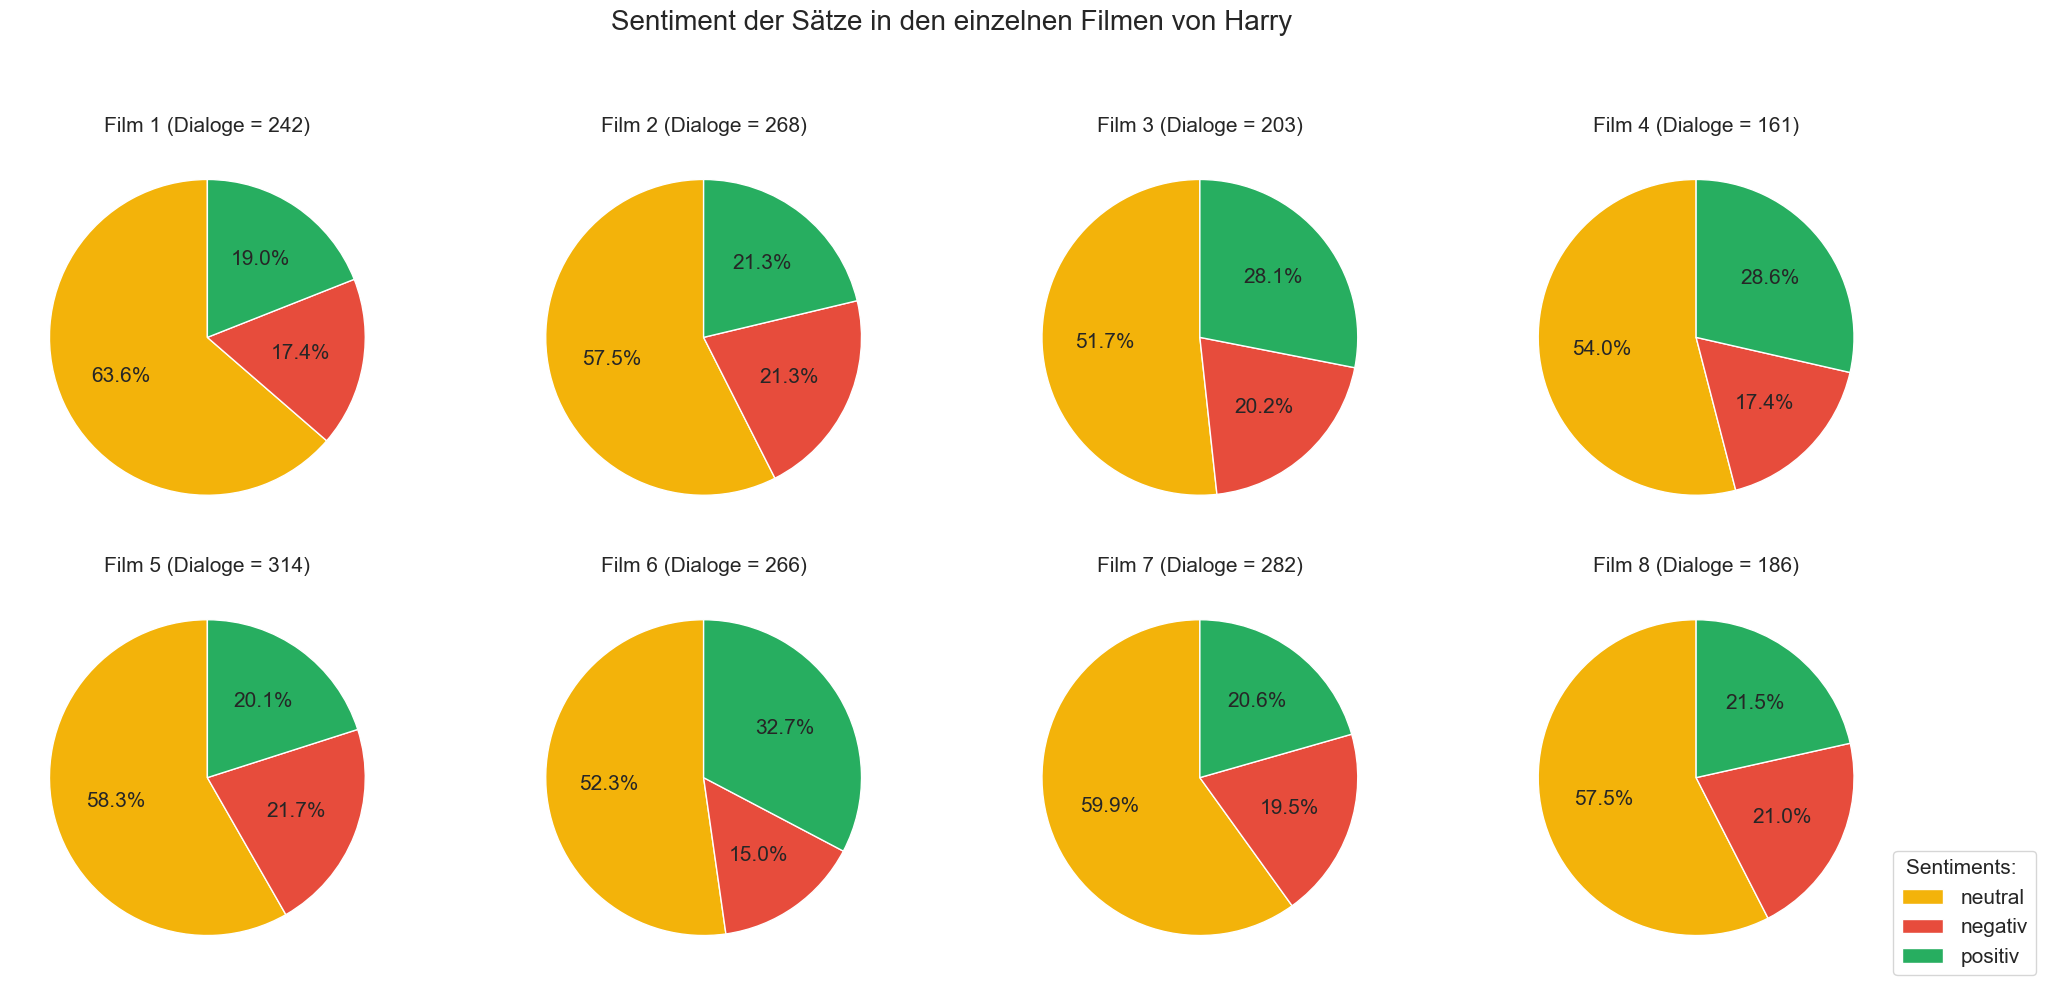

In [77]:
#### Sentiment Analyse
## Unterteilung Positiv, Negativ, Neutral für Harry in allen Filmen
#Dialog Harry
df_dialHarry = df_ChDiCp[df_ChDiCp['Character ID'] == 1]
df_dialHarry

## Grafik erstellen
sns.set_style('whitegrid') 
plt.figure(figsize=(20,10))

for i in Movie['Movie ID']:
    movie = df_dialHarry[df_dialHarry['Movie ID'] == i]

    # für jeden Film Sentiment aufsummieren
    AnzahlposSätze = movie['PosFlag'].sum()
    AnzahlnegSätze = movie['NegFlag'].sum()
    AnzahlneuSätze = movie['NeuFlag'].sum()

    # Daten und Labels festlegen
    y = [AnzahlneuSätze,AnzahlnegSätze,AnzahlposSätze]
    x = ['neutral', 'negativ', 'positiv']

    plt.subplot(2,4,i) 
    summe = AnzahlnegSätze+ AnzahlneuSätze + AnzahlposSätze
    plt.title(f'Film {i} (Dialoge = {summe})',  size = 15)
    plt.pie(x= y, colors = [ '#F3B30A','#E74C3C','#27AE60'],autopct = '%1.1f%%', textprops = {'fontsize': 15}, startangle= 90.0) 
    

plt.tight_layout(h_pad = 3)
plt.suptitle('Sentiment der Sätze in den einzelnen Filmen von Harry', fontsize = 20) 
plt.subplots_adjust(top = 0.85) 
plt.legend(title = 'Sentiments: ', labels = x, loc =(1,0), prop = {'size': 15}, title_fontsize = 15)
plt.show()

In [62]:
#### Emotion Analyse ####
#### Version NRClex 3.0.0

# Lexikon anschauen
NRCLex.lexicon


{'abacus': ['trust'],
 'abandon': ['fear', 'negative', 'sadness'],
 'abandoned': ['anger', 'fear', 'negative', 'sadness'],
 'abandonment': ['anger', 'fear', 'negative', 'sadness', 'surprise'],
 'abba': ['positive'],
 'abbot': ['trust'],
 'abduction': ['fear', 'negative', 'sadness', 'surprise'],
 'aberrant': ['negative'],
 'aberration': ['disgust', 'negative'],
 'abhor': ['anger', 'disgust', 'fear', 'negative'],
 'abhorrent': ['anger', 'disgust', 'fear', 'negative'],
 'ability': ['positive'],
 'abject': ['disgust', 'negative'],
 'abnormal': ['disgust', 'negative'],
 'abolish': ['anger', 'negative'],
 'abolition': ['negative'],
 'abominable': ['disgust', 'fear', 'negative'],
 'abomination': ['anger', 'disgust', 'fear', 'negative'],
 'abort': ['negative'],
 'abortion': ['disgust', 'fear', 'negative', 'sadness'],
 'abortive': ['negative', 'sadness'],
 'abovementioned': ['positive'],
 'abrasion': ['negative'],
 'abrogate': ['negative'],
 'abrupt': ['surprise'],
 'abscess': ['negative', 'sad

{'joy': 1003, 'positive': 2478, 'trust': 1731, 'fear': 1343, 'negative': 2218, 'anticipation': 1380, 'surprise': 685, 'anger': 858, 'disgust': 893, 'sadness': 1129}
  Emotion Classification  Emotion Count
1               positive           2478
4               negative           2218
2                  trust           1731
5           anticipation           1380
3                   fear           1343
9                sadness           1129
0                    joy           1003
8                disgust            893
7                  anger            858
6               surprise            685
Häufigste Emotion:  [('positive', 0.18063857705204842)]


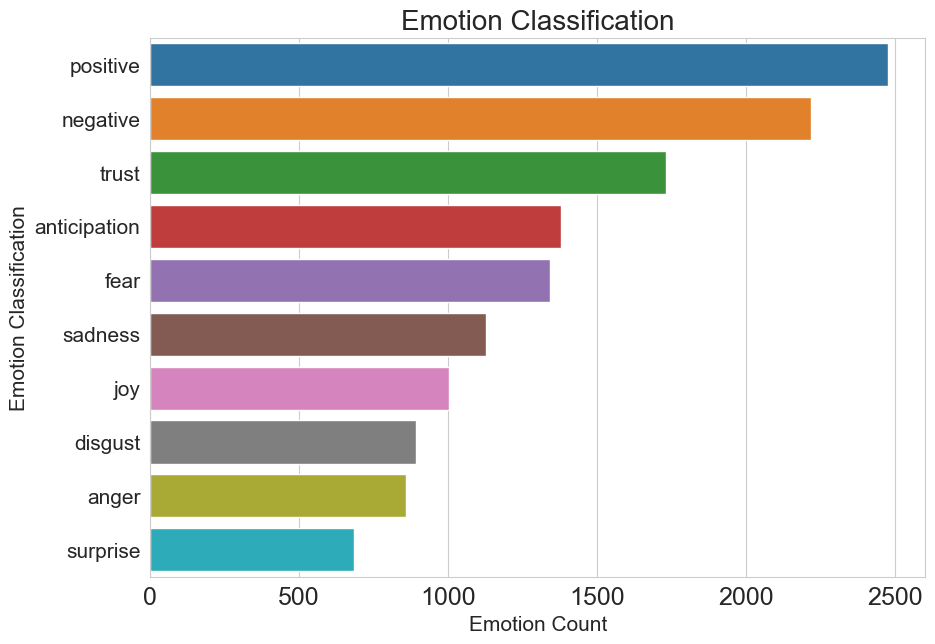

  Emotion Classification  Emotionfrequency
4               positive          0.180639
5               negative          0.161685
2                  trust          0.126185
9           anticipation          0.100598
0                   fear          0.097901
6                sadness          0.082301
8                    joy          0.073116
7                disgust          0.065097
1                  anger          0.062546
3               surprise          0.049934


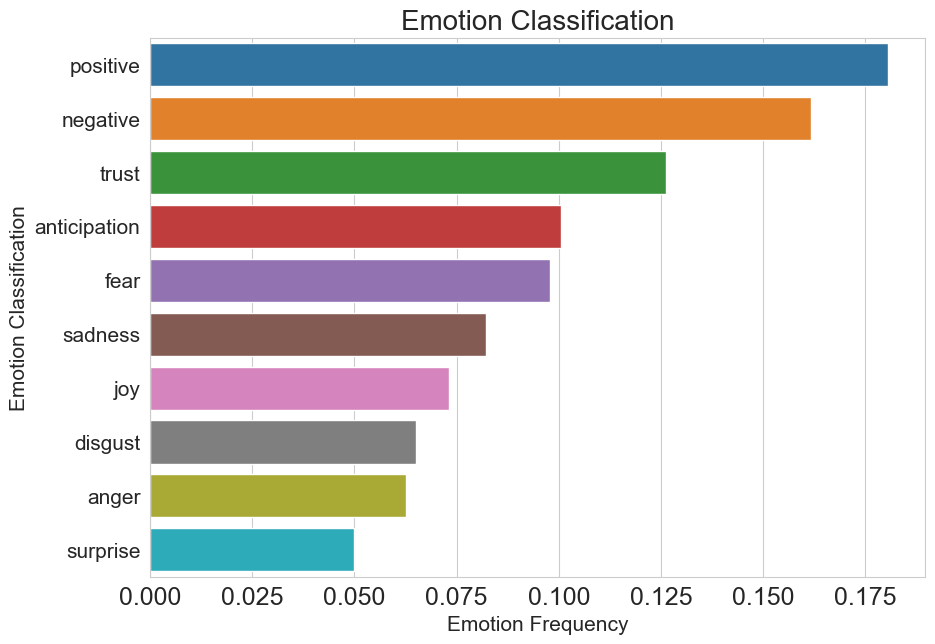

In [87]:
#### Emotion Analyse
# Vorbereitung
str_dialoge = ' '.join(df_ChDiCp['Dialogue'])
str_dialoge
# NRClex anwenden
dialoge_object = NRCLex(str_dialoge)
dialoge_object

### Emotionen aus dem ganzen Text 


## absolute Werte
# emotionale Rohwerte
data = dialoge_object.raw_emotion_scores 
print(data)

# Erkenntnisse in Data Frame abspeichern
emotion_df = pd.DataFrame.from_dict(data,orient = 'index')
emotion_df= emotion_df.reset_index()
emotion_df = emotion_df.rename(columns={'index': 'Emotion Classification', 0: 'Emotion Count'})
emotion_df = emotion_df.sort_values(by = ['Emotion Count'], ascending =False)
print(emotion_df)

# häufigste Emotion
print('Häufigste Emotion: ', dialoge_object.top_emotions)

## Grafik erstellen
sns.set_style('whitegrid')
plt.figure(figsize= (10,7))
sns.barplot(x='Emotion Count' ,y = 'Emotion Classification', data = emotion_df)
plt.xlabel('Emotion Count', fontsize = 15) 
plt.ylabel('Emotion Classification', fontsize = 15) 
plt.title('Emotion Classification', fontsize = 20)
plt.rc('ytick', labelsize = 15)
plt.show()



## relative Werte
dialoge_object.affect_dict # Wort der Texte Affekte zeigen
affect_df = pd.DataFrame.from_dict(dialoge_object.affect_dict, orient ='index')
affect_df

# relative Häufigkeiten der Emotionen
data1 = dialoge_object.affect_frequencies
# Fehler in NRClex 3.0, deshalb löschen -> 4.0 gefixt, allerdings mein PC hat diese Version nicht
del data1['anticip']

# in Data Frame abspeichern
frequencieemotion_df = pd.DataFrame.from_dict(data1,orient = 'index')
frequencieemotion_df= frequencieemotion_df.reset_index()
frequencieemotion_df = frequencieemotion_df.rename(columns={'index': 'Emotion Classification', 0: 'Emotionfrequency'})
frequencieemotion_df = frequencieemotion_df.sort_values(by = ['Emotionfrequency'], ascending =False)
print(frequencieemotion_df)

## Grafik erstellen
sns.set_style('whitegrid') 
plt.figure(figsize= (10,7))
sns.barplot(x='Emotionfrequency' ,y = 'Emotion Classification', data = frequencieemotion_df)
plt.xlabel('Emotion Frequency', fontsize = 15) 
plt.ylabel('Emotion Classification', fontsize = 15)
plt.title('Emotion Classification', fontsize = 20) 
plt.rc('ytick', labelsize = 15)
plt.show()

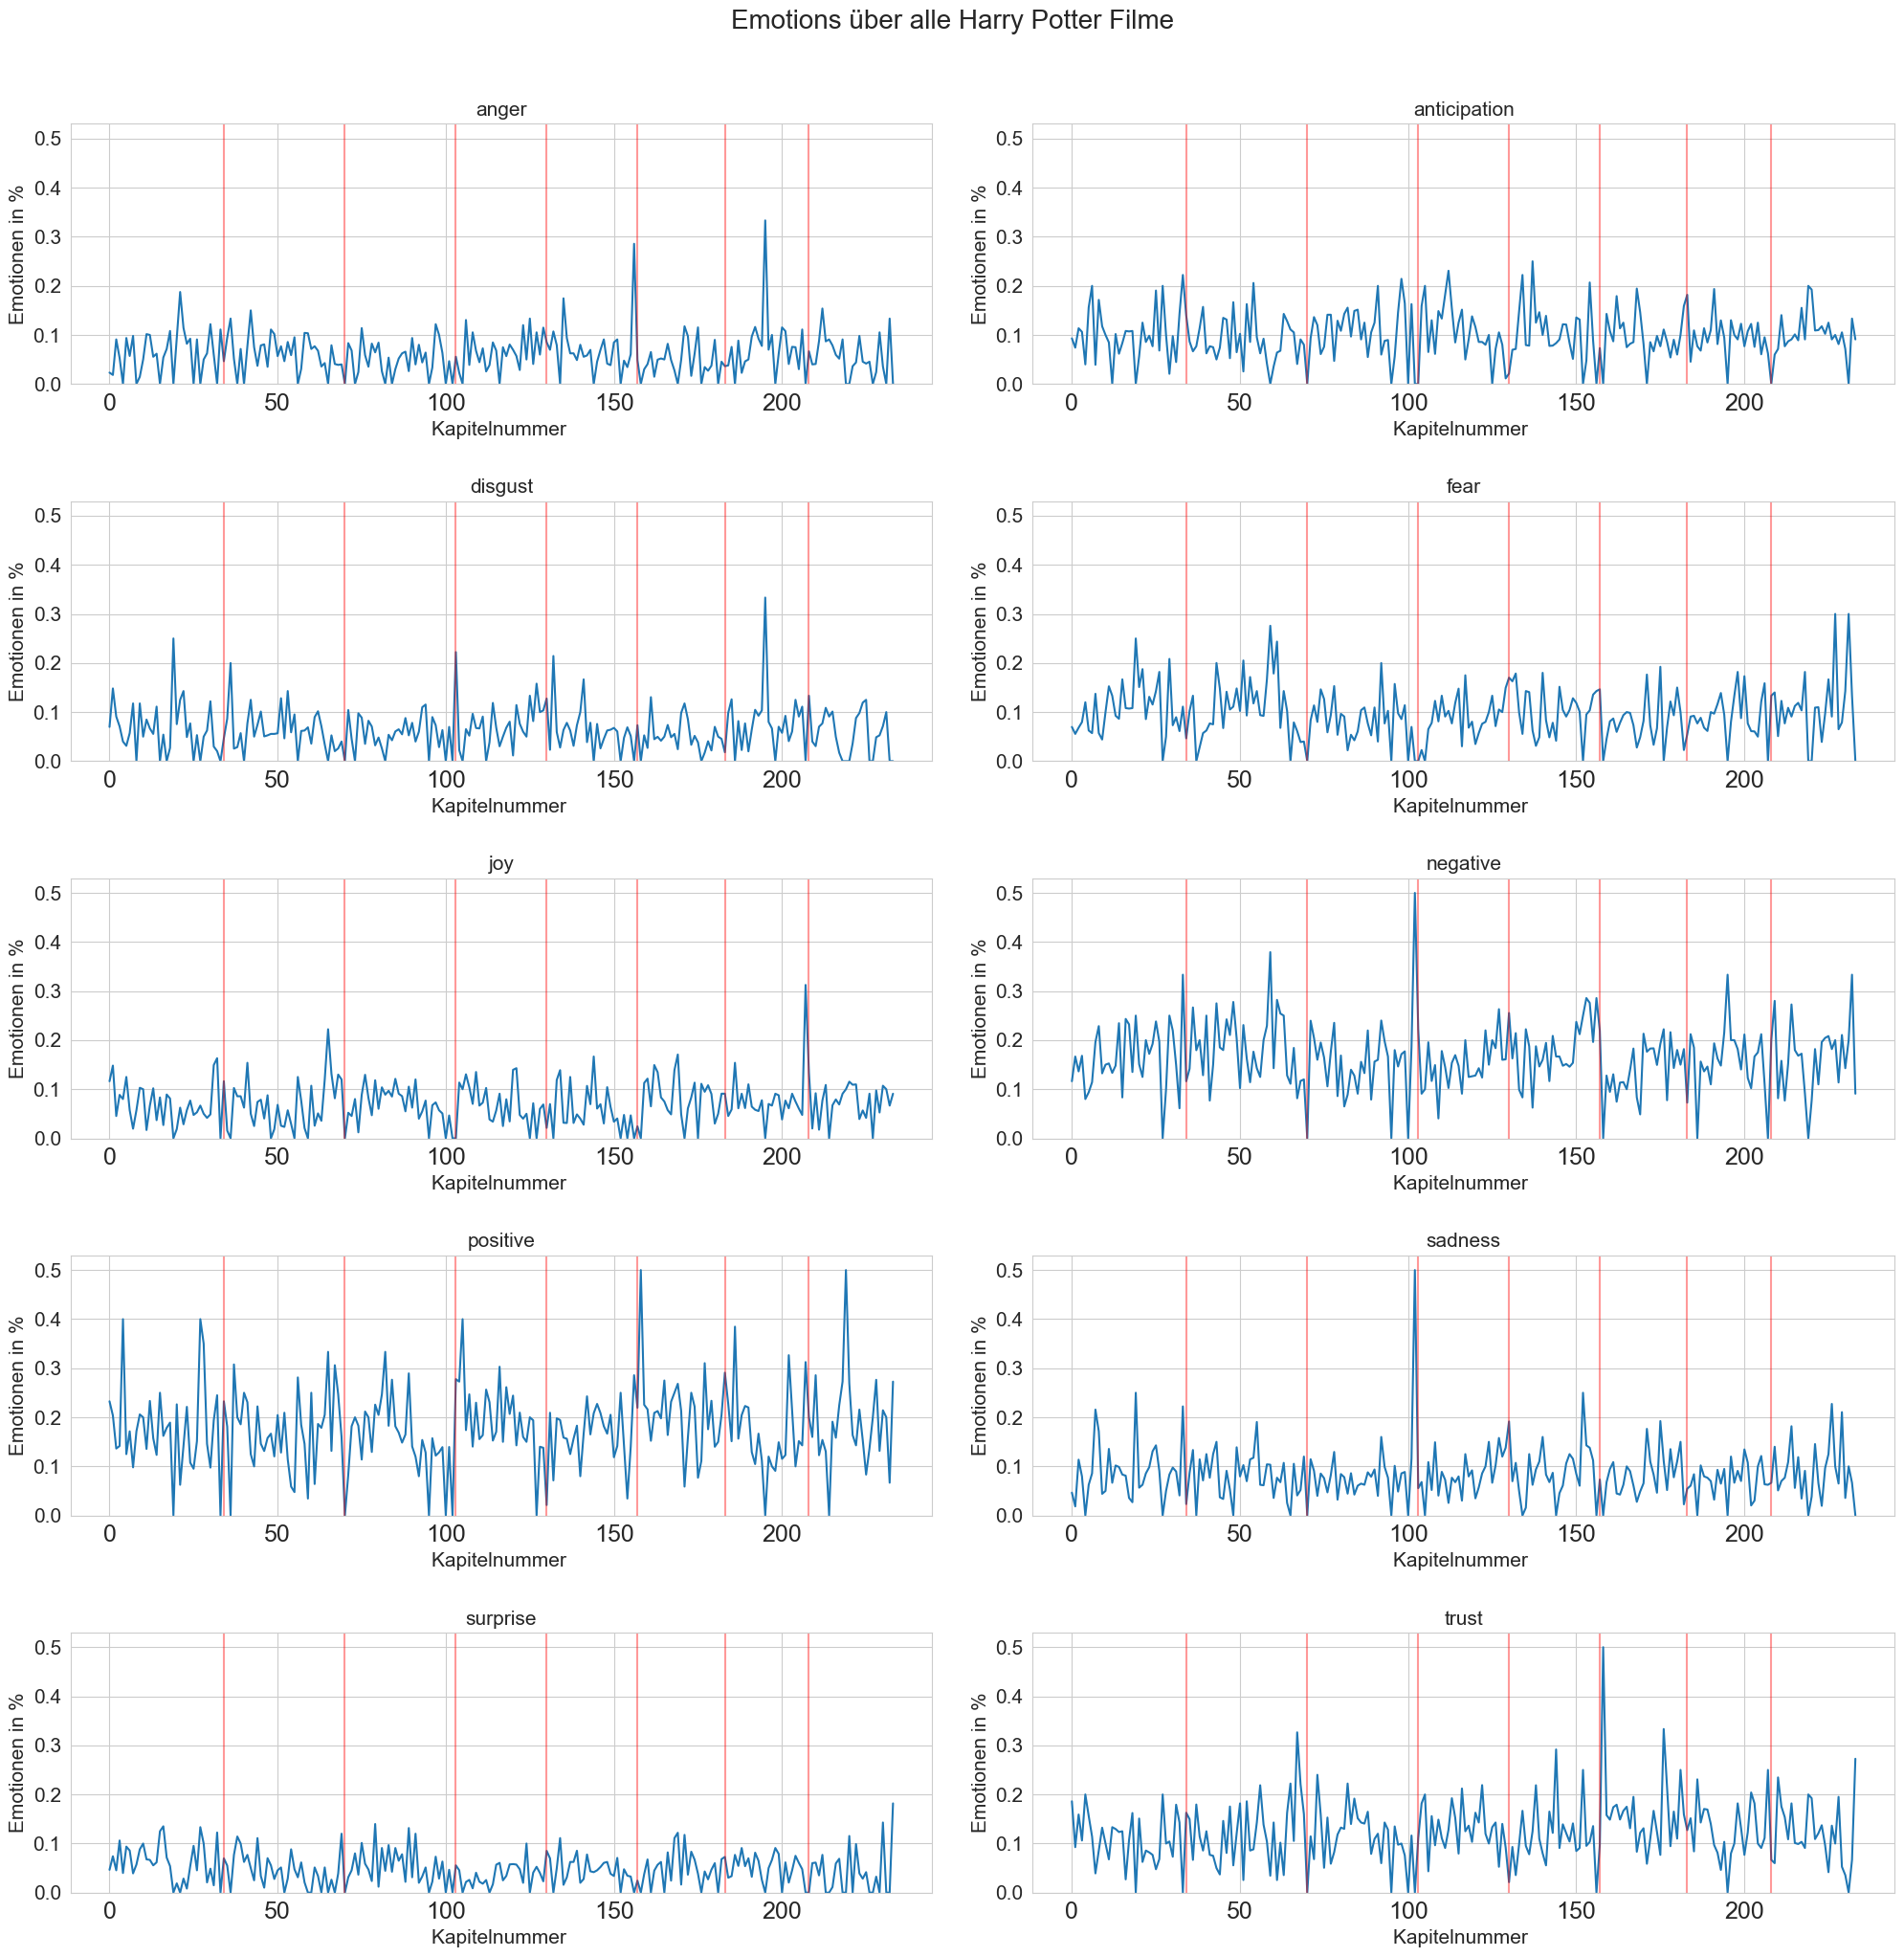

In [107]:
#### Emotion Analyse
### jede Emotion durch alle Kapitel durchgehen

#Dictionary über die Emotionen
emotions = {
    'anger': [],
    'anticipation': [],
    'disgust': [],
    'fear': [],
    'joy': [],
    'negative': [],
    'positive': [],
    'sadness': [],
    'surprise': [],
    'trust': []
    }

#pro Chapter Dialoge gruppieren
ch_dialog = df_ChDiCp.groupby('Chapter ID', as_index = False)['Dialogue']
print(ch_dialog)

# Pro Kapitel Dialoge zusammenfügen
for i, ch in ch_dialog: 
    str_chapter = ' '.join(ch)
    # Anwendung der NRClex
    text_object = NRCLex(str_chapter)

    # emotionale Rohwerte
    emo_dict = text_object.raw_emotion_scores
    # print(emo_dict)
    
    # Emotionenanzahl der Kaptiels aufaddieren
    abs_sum = sum(emo_dict.values())

    # nicht in jedem Kapitel müssen Emotionen vorhanden sein --> jede Emotion besitzt Zahl 0
    if abs_sum == 0:        
        for emotion in emotions:
            emotions[emotion].append(0)
        # man bricht hier große for-schleife ab und beginnt neuen Loop
        continue

    # Falls Kapitel Emotionen besitzt
    # Dictionary emotions füllen mit relative Werten oder 0, falls Emotion nicht vorhanden
    for key in emotions:
        if key in emo_dict:
            emotions[key].append(emo_dict[key] / abs_sum)
        else: 
            emotions[key].append(0)


## Grafik erstellen

plt.figure(figsize = (20, 20))
plt.subplots_adjust(hspace = .5, wspace=.1)
plt.suptitle('Emotions über alle Harry Potter Filme', fontsize=20, y=1.02)
plt.subplots_adjust(top=0.88) 

# Subplot für jede Emotion erstellen
for i, emotion in enumerate(emotions):
    i +=1 
    liste = emotions[emotion]
   
    plt.subplot(5,2,i)
    plt.title(emotion, fontsize = 15) 
    sns.lineplot(liste) 
    plt.xlabel('Kapitelnummer ', fontsize = 15)
    plt.ylabel('Emotionen in %', fontsize = 15) 
    plt.ylim(0,0.53)
    # Filmgrenzen, die vorher mal herausgefiltert wurden, als rote Linie einzeichnen (=[34,70,103,130,157,183,208])
    for x in Filmgrenzen[:7]:
        plt.axvline(x=x, color = 'red', alpha = 0.4, label = f'Filmende Kapitel = {x}')
   
plt.tight_layout(h_pad = 3, w_pad = 3)
plt.show()


C:\Users\ACG\AppData\Local\Temp\ipykernel_17628\4284522949.py:41: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  personen = totalword.sort_values('wordcount',ascending = False).CharacterName[0:10]


                                      paar  score
0         (harry potter, hermione granger)    215
2              (harry potter, ron weasley)    138
1         (harry potter, albus dumbledore)    136
3            (harry potter, rubeus hagrid)     96
10         (hermione granger, ron weasley)     88
4            (harry potter, severus snape)     52
8                (harry potter, voldemort)     50
7              (harry potter, remus lupin)     39
18       (albus dumbledore, rubeus hagrid)     31
6       (harry potter, minerva mcgonagall)     30
9     (hermione granger, albus dumbledore)     30
23           (albus dumbledore, voldemort)     29
19       (albus dumbledore, severus snape)     28
11       (hermione granger, rubeus hagrid)     21
20     (albus dumbledore, horace slughorn)     20
5          (harry potter, horace slughorn)     17
24            (ron weasley, rubeus hagrid)     17
21  (albus dumbledore, minerva mcgonagall)     16
17         (albus dumbledore, ron weasley)     15


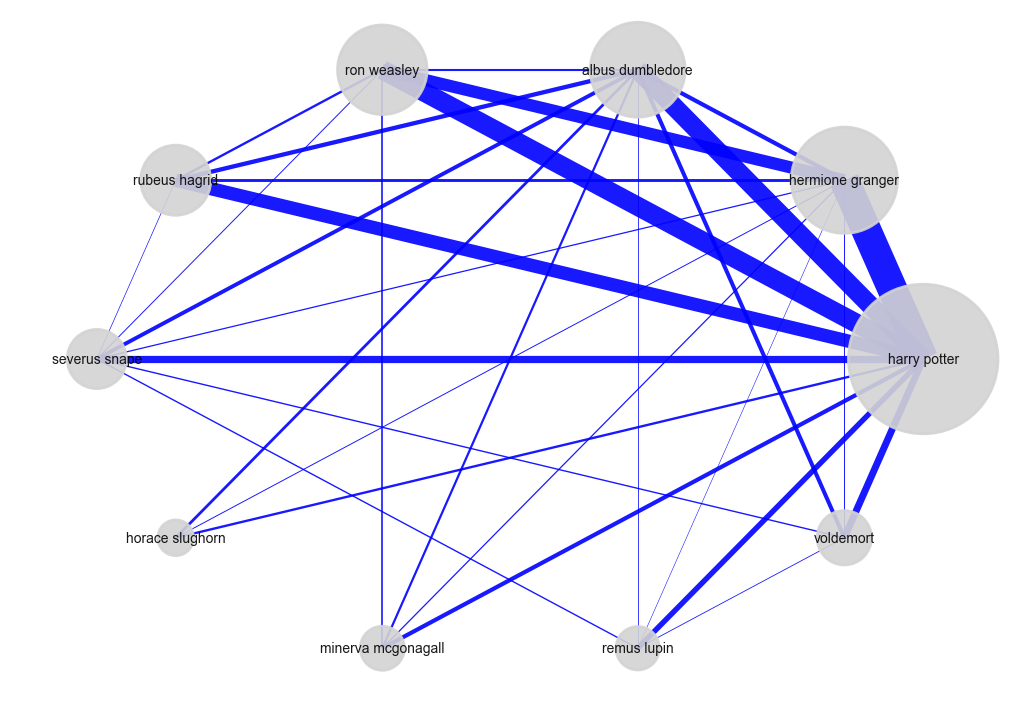

In [119]:
#### Netzwerk Analyse ###
### Netzwerk: Beziehungen zwischen den 10 Menschen, die ammeisten reden

# Vorbereitung:
charaktere = df_characters['Character Name'].str.lower().to_list()
charaktere


## Prüft, ob ein Dialog (d.h. Zeile) eine Person enthält
def count_person_1and2words(row, charakter):
    used_char = []

    # Jede Person wird einmal durchgegangen
    for char in charakter:
        if ' ' in char:
            # Prüft, ob ein 2-Wort-Name komplett vorkommt
            if char in ' '.join(row):
                used_char.append(char)
            else:
                #Prüft ob ein Teil eines 2-Wort-Namens vorkommt
                s = char.split()
                if s[0] in row or s[1] in row:
                    used_char.append(char)
        else:
            # Prüft ob ein 1-Wort-Name als ganzes vorkommt
            if char in row:
                used_char.append(char)
    # Liste zurückgegeben von den Namen, die vorkommen
    return used_char

# Funktion count_person_1and2words anwenden
df_ChDiCp['chara'] = df_ChDiCp['Tokens'].apply(count_person_1and2words, charakter = charaktere)
df_ChDiCp

# alle Character Namen in der Spalte klein schreiben
df_ChDiCp['Character Name'] = df_ChDiCp['Character Name'].str.lower()
df_ChDiCp

# die 10 Personen die ammeisten reden, abspeichern
totalword['CharacterName'] = totalword['CharacterName'].str.lower()
personen = totalword.sort_values('wordcount',ascending = False).CharacterName[0:10]
personen



## zählt in jeder Zeile die Tupel der Spalten (Character Name, chara)
def count_tupel(row, paar):
    zw_summe = 0
    # alle Möglichkeiten (Character Name, chara) und (chara, Character Name) prüfen
    if row['Character Name'] == paar[0]:
        if paar[1] in row['chara']:
                zw_summe += 1
    if row['Character Name'] == paar[1]:
        if paar[0] in row['chara']:
                zw_summe += 1
    return zw_summe

# Funktion count_tupel anwenden
score = []
# print(list(combinations(personen,2))) # Ausgabe der 2er-Combinationen der Personen
for paar in combinations(personen,2):
    zw_summe = 0
    score.append(sum(df_ChDiCp.apply(count_tupel, args = (paar,), axis = 1)))
score

# Speichern der Ergebnisse in einem Data Frame
Tupelchar = pd.DataFrame({'paar': combinations(personen,2), 'score': score})
print(Tupelchar.sort_values('score', ascending = False)) 


## Grafik erstellen 
G = nx.Graph()
edges = list(Tupelchar[Tupelchar.score > 3].paar)
weights = list(Tupelchar[Tupelchar.score > 3].score)

# Knoten mit Verbindungen erstellen
G.add_edges_from(edges)


#je mehr Beziehungen eine Person hat, desto größer soll ihre Node sein; wir summieren für jede Person ihre Beziehungsnummer zusammen
summe = []
# jede Person, die in paar enthalten sind durchgehen
for node in list(G):
    zw_summe = 0
    # für jede Person von dessen Paaren die weights aufsummieren
    for (edge, weight) in zip(edges, weights):
        if node in edge:
            zw_summe += weight
    summe.append(zw_summe*15)

## Grafik erstellen
plt.figure(figsize=(10,7))
# Grafik zeichnen
nx.draw_circular(G,
                with_labels = True, edge_color ='blue', width = [(weight/2)/5 for weight in weights], node_size = summe,
                linewidths = 2, node_color = 'lightgray', node_shape = 'o', font_size = 10, font_color ='black',  alpha = 0.9)

plt.show()

In [67]:
#### Data Frame abspeichern ####
df_ChDiCp.to_csv('../Utils/AnalyseDaten.csv')

In [68]:
# Daten einlesung und zusammenführen
# df_dialHarry = df_ChDi[df_ChDi['Character ID'] == 1]
# df_dialRon = df_ChDi[df_ChDi['Character ID'] == 2]
# df_dialHerm = df_ChDi[df_ChDi['Character ID'] == 3]
# df_dialDumbl = df_ChDi[df_ChDi['Character ID'] == 4]
# df_dialHagr = df_ChDi[df_ChDi['Character ID'] == 5]
# df_dialSnape = df_ChDi[df_ChDi['Character ID'] == 6]
# df_dialVold = df_ChDi[df_ChDi['Character ID'] == 9]
# df_characters_list = [df_dialHarry,df_dialRon,df_dialHerm,df_dialDumbl,df_dialHagr,df_dialSnape,df_dialVold] 


# df_film1 = df_ChDiCp[df_ChDiCp['Movie ID'] == 1]
# df_film2 = df_ChDiCp[df_ChDiCp['Movie ID'] == 2]
# df_film3 = df_ChDiCp[df_ChDiCp['Movie ID'] == 3]
# df_film4 = df_ChDiCp[df_ChDiCp['Movie ID'] == 4]
# df_film5 = df_ChDiCp[df_ChDiCp['Movie ID'] == 5]
# df_film6 = df_ChDiCp[df_ChDiCp['Movie ID'] == 6]
# df_film7 = df_ChDiCp[df_ChDiCp['Movie ID'] == 7]
# df_film8 = df_ChDiCp[df_ChDiCp['Movie ID'] == 8]
# film_dial_list = [df_film1, df_film2, df_film3,  df_film4, df_film5, df_film6, df_film7, df_film8]


# # Als Balkendiagram statt wie im Code als Pie-Diagramm
# #### Sentiment Analyse
# ### Sentimentscore in Gruppen zusammenfügen
# df_ChDiCp['PosFlag'] = df_ChDiCp.CompScore.apply(lambda x: 1 if x >= 0.05 else 0)
# df_ChDiCp['NegFlag'] = df_ChDiCp.CompScore.apply(lambda x: 1 if x <= -0.05 else 0)
# df_ChDiCp['NeuFlag'] = df_ChDiCp.CompScore.apply(lambda x: 1 if x < 0.05 and x > -0.05 else 0) 
# df_ChDiCp

# # für jeden Film einzelnd
# sns.set_style('whitegrid') # Hintergrund vom Grid
# #plt.subplots_adjust(wspace = 0.9, hspace = 0.9)
# #plt.figure(figsize= (100,100))
# # fig, _ = plt.subplots(4,2) #was sind
# # fig.set_figheight(10)
# # fig.set_figwidth(10)
# plt.figure(figsize =(20,10))

# for i in Movie['Movie ID']:
#     movie = df_ChDiCp[df_ChDiCp['Movie ID'] == i]

#     AnzahlposSätze = movie['PosFlag'].sum()
#     AnzahlnegSätze = movie['NegFlag'].sum()
#     AnzahlneuSätze = movie['NeuFlag'].sum()

#     y = [AnzahlposSätze,AnzahlneuSätze,AnzahlnegSätze]
#     x = ['positiv','neutral', 'negativ']
#     plt.subplot(2,4,i)
#     #plt.title(str(Movie['Movie Title']))
#     plt.title('Film '+ str(i))
#     sns.barplot(x= x ,y = y )
#     plt.ylim(0,700)

# # plt.figures('Film', figsize =(10,7))
# plt.tight_layout(h_pad = 3) #fig
# # plt.figure(figsize= (20,10))
# #  plt.title('Sentiment der Sätze in den einzelnen Filmen', fontsize = 20)
# # plt.xlabel('Seniment der Sätze', fontsize = 15)
# # plt.ylabel('Anzahl an Sätzen', fontsize = 15)
# plt.suptitle('Sentiment der Sätze in den einzelnen Filmen', fontsize = 20)
# plt.subplots_adjust(top = 0.85)
# plt.show()

# #insgesamt über alle Filme
# AnzahlposSätze = df_ChDiCp['PosFlag'].sum()
# AnzahlnegSätze = df_ChDiCp['NegFlag'].sum()
# AnzahlneuSätze = df_ChDiCp['NeuFlag'].sum()

# y = [AnzahlposSätze,AnzahlneuSätze,AnzahlnegSätze]
# x = ['positiv','neutral', 'negativ']

# sns.set_style('whitegrid')
# plt.figure(figsize= (10,7))
# sns.barplot(x= x ,y = y )
# plt.xlabel('Seniment der Sätze', fontsize = 15)
# plt.ylabel('Anzahl an Sätzen', fontsize = 15)
# plt.title('Sentiment der Sätze', fontsize = 20)
# plt.show()